# **Scientific Computing From Scratch**

# **Introductions to graph neural networks and PyTorch Geometric (PyG)**

Lecturer: Rishikesh Magar

Date: 2025/07/15

Note: This notebook covers the basics and the applications of graph neural network and PyTorch Geometric.

Disclaimer: The content includes references to materials available on the open internet. The references are listed at the end of the notebook. Citations for published articles are provided in the relevant sections. A good chunk of the content has been borrowed from previous years notebooks with some modifications

In [ ]:
!pip3 install torch torchvision torchaudio

  Using cached torch-2.7.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.6.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.6.80-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.5.1.17-py3-none-manylinux_2_28_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.6.4.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.3.0.4-py3-n

In [ ]:
# Find the CUDA version PyTorch was installed with
!python -c "import torch; print(torch.version.cuda)"

12.4


In [ ]:
# PyTorch version
!python -c "import torch; print(torch.__version__)"

2.6.0+cu124


In [ ]:
# Check out https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
!pip install torch_geometric
!pip install rdkit

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 111.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.4/950.4 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 64.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import MLP, GCNConv, GATv2Conv, global_add_pool

import rdkit
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import networkx as nx
from rdkit import Chem, RDLogger
from typing import List, Tuple, Union

In [ ]:
print(f"PyTorch: {torch.__version__}")
print(f"RDKit: {rdkit.__version__}")
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
if torch.cuda.is_available():
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

PyTorch: 2.6.0+cu124
RDKit: 2025.03.3
__CUDNN VERSION: 90300
__Number CUDA Devices: 1
__CUDA Device Name: Tesla T4
__CUDA Device Total Memory [GB]: 15.828320256


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

## **Introduction -- Why graph?**

Graphs are everywhere in the real world—many objects are best understood through their relationships with others. When we represent a collection of items and their connections, we naturally arrive at a graph structure. To work with this kind of data, researchers have created a special type of neural network designed specifically for graphs, known as Graph Neural Networks (GNNs).

Graphs are sets of vertices connected by edges.

Graphs are general language/data structure for describing and analyzing relational/interacting objects.


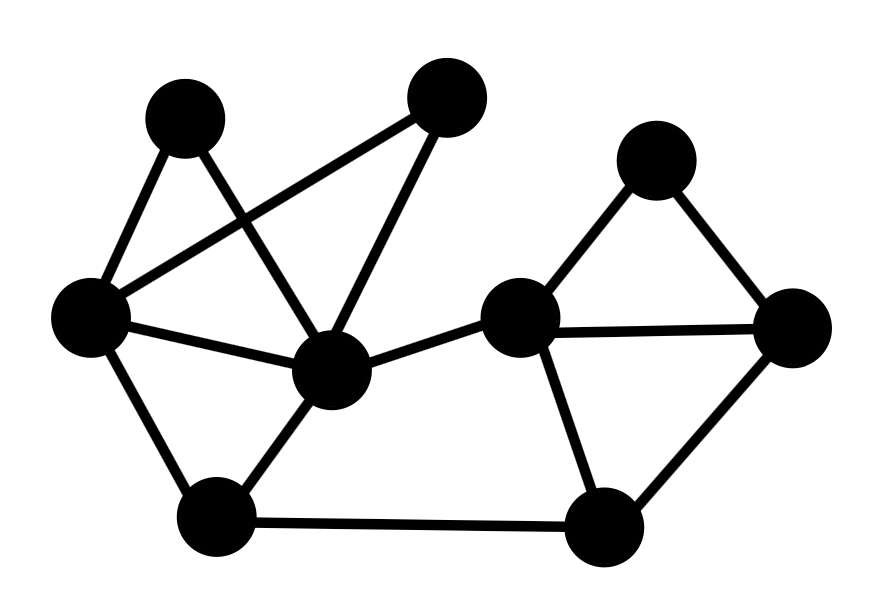

Many types of graphs

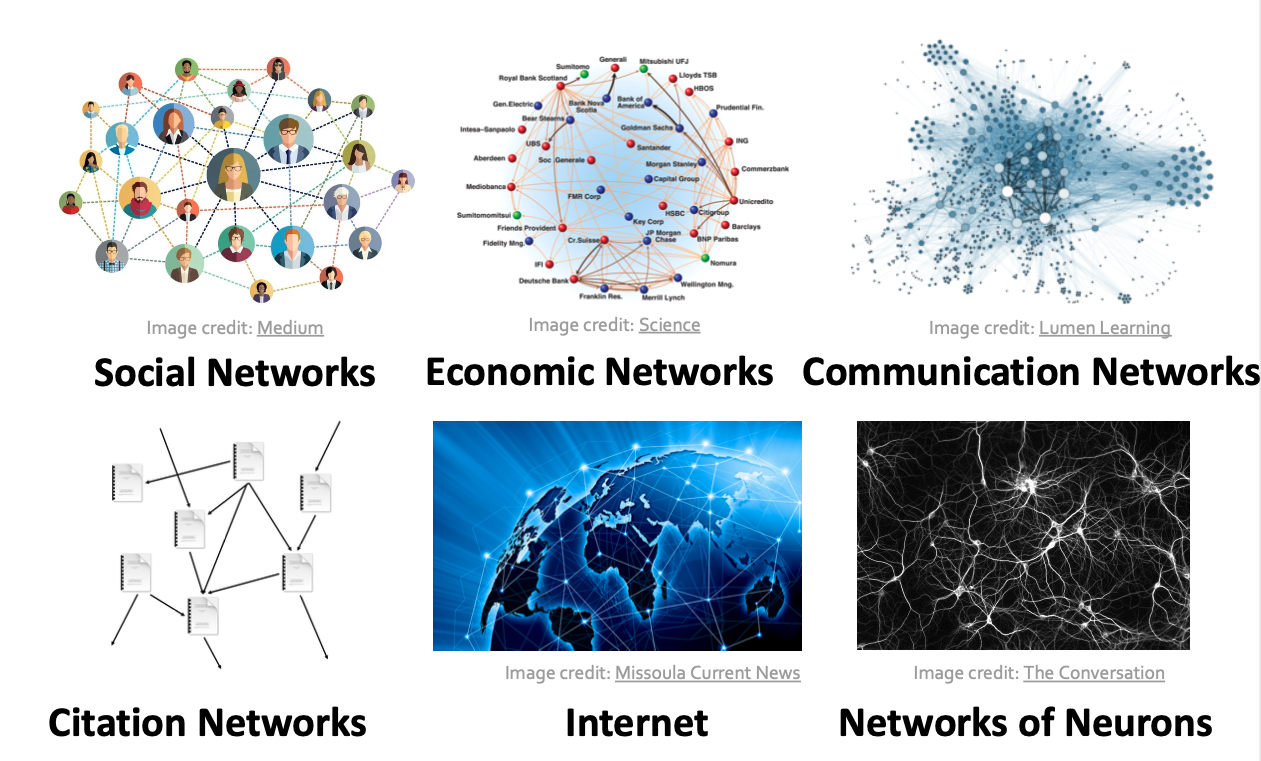

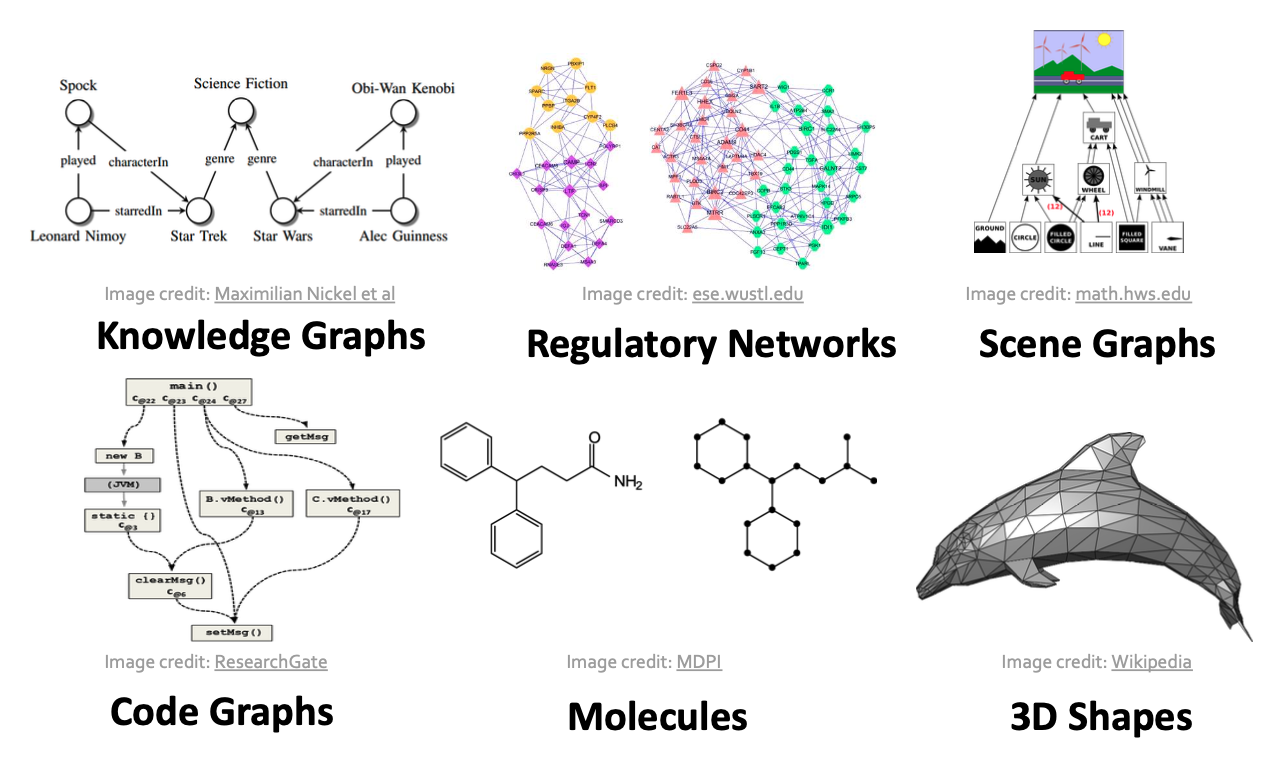

Graph machine learning tasks:

*   Graph-level prediction (Our focus today)
*   Node-level prediction
*   Edge-level prediction
*   Generation
*   Subgraph-level tasks



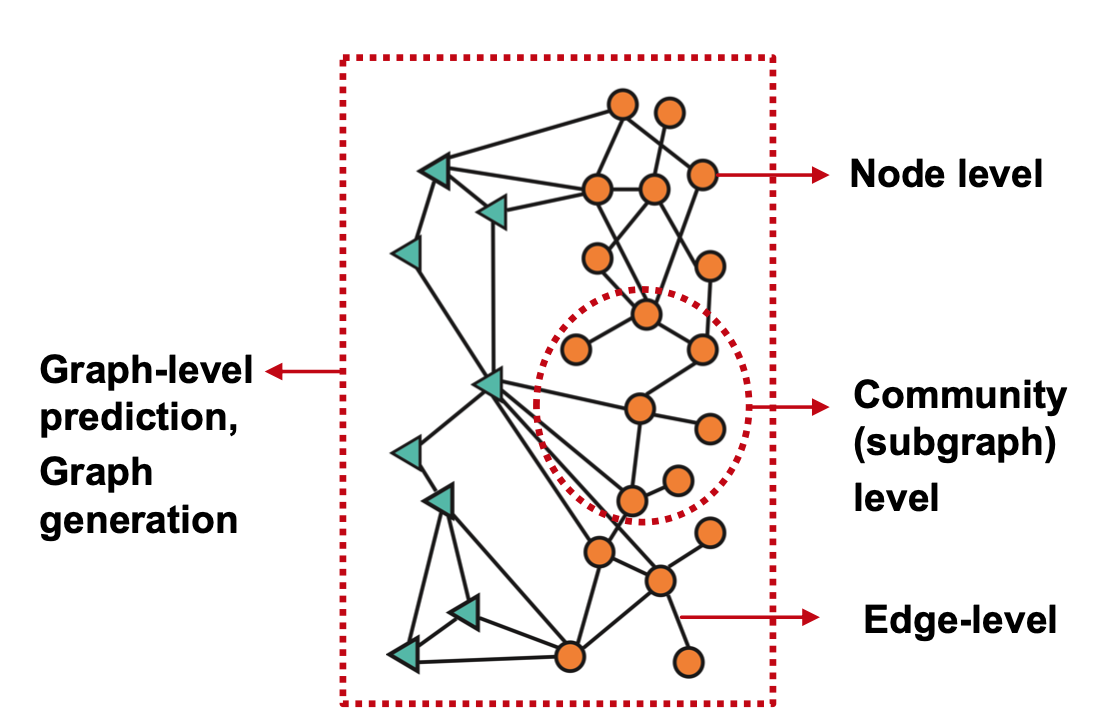

Graph machine learning in science

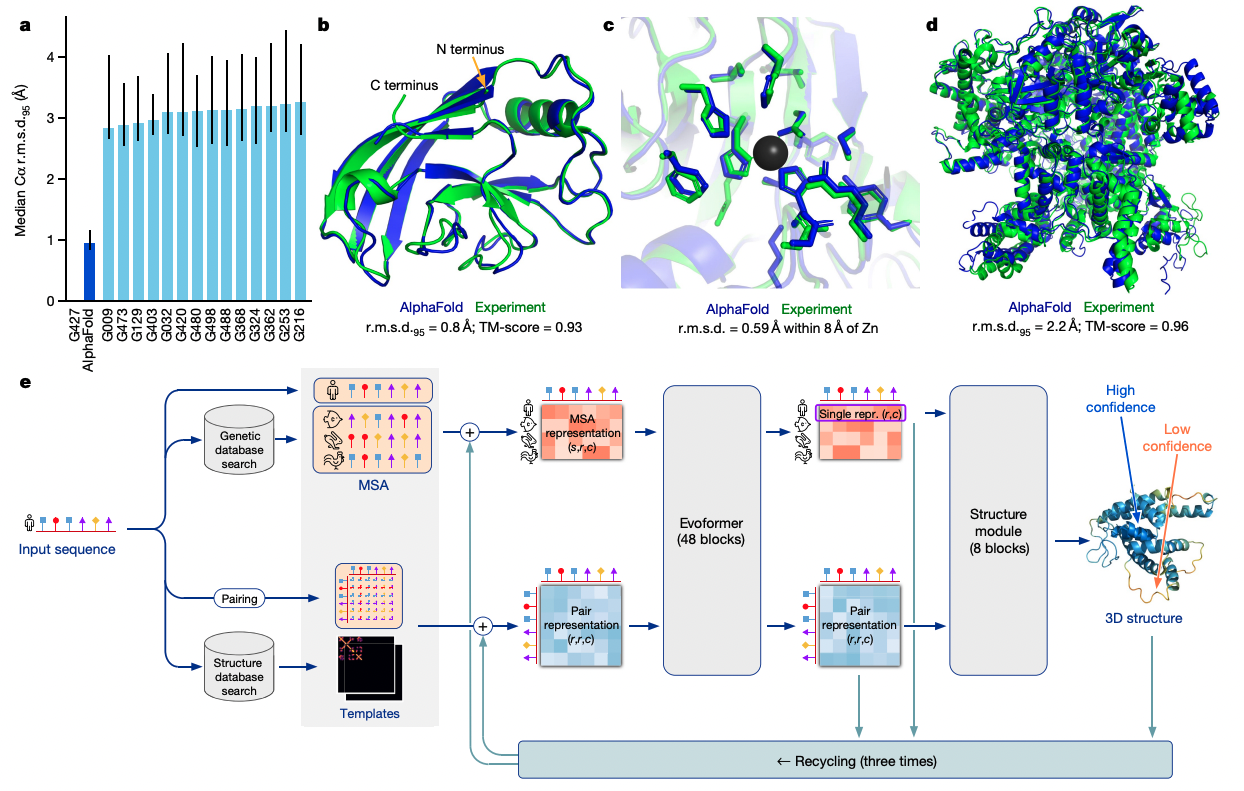

Jumper, John, et al. "Highly accurate protein structure prediction with AlphaFold." nature 596.7873 (2021): 583-589.

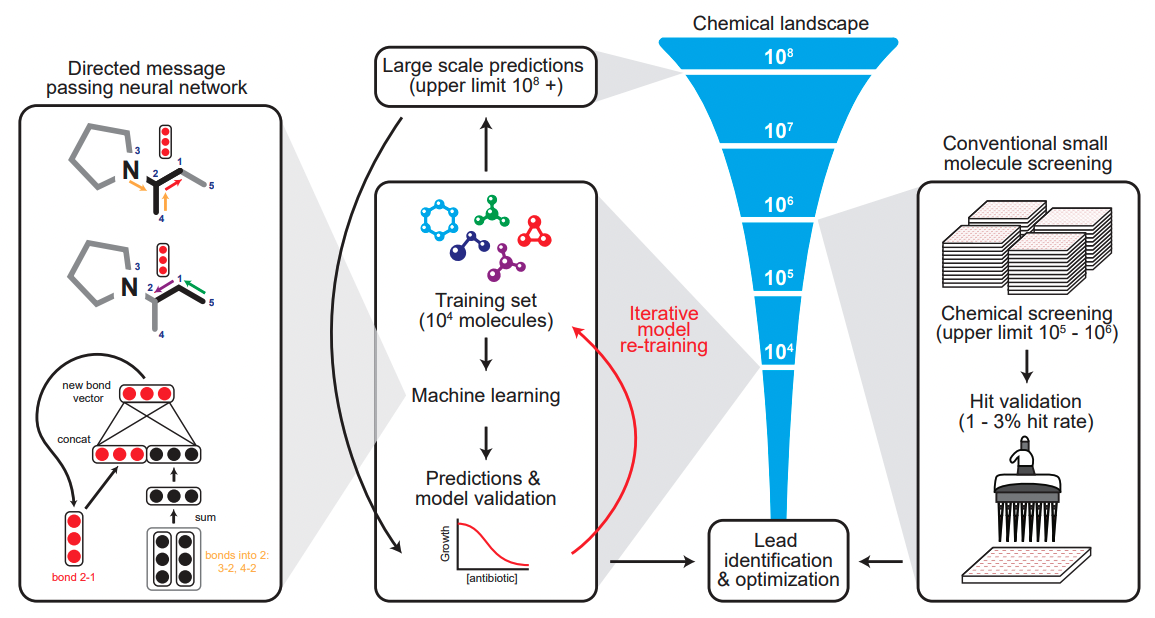

Stokes, Jonathan M., et al. "A deep learning approach to antibiotic discovery." Cell 180.4 (2020): 688-702.

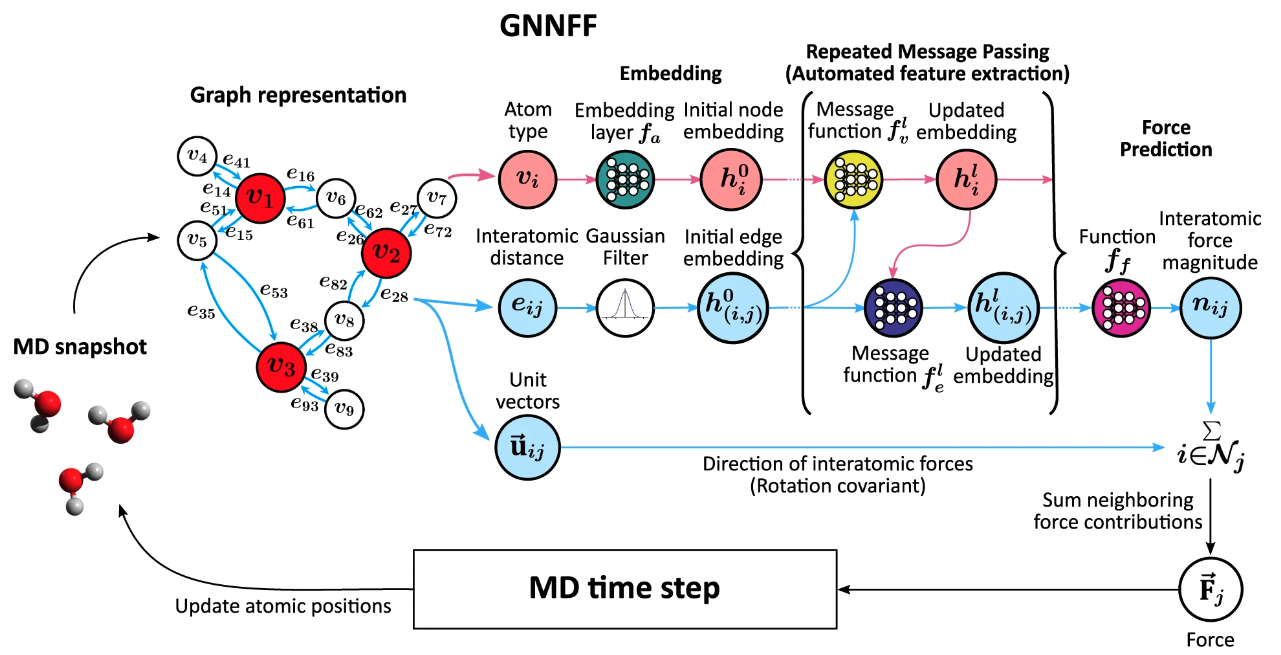

Park, Cheol Woo, et al. "Accurate and scalable graph neural network force field and molecular dynamics with direct force architecture." npj Computational Materials 7.1 (2021): 73.

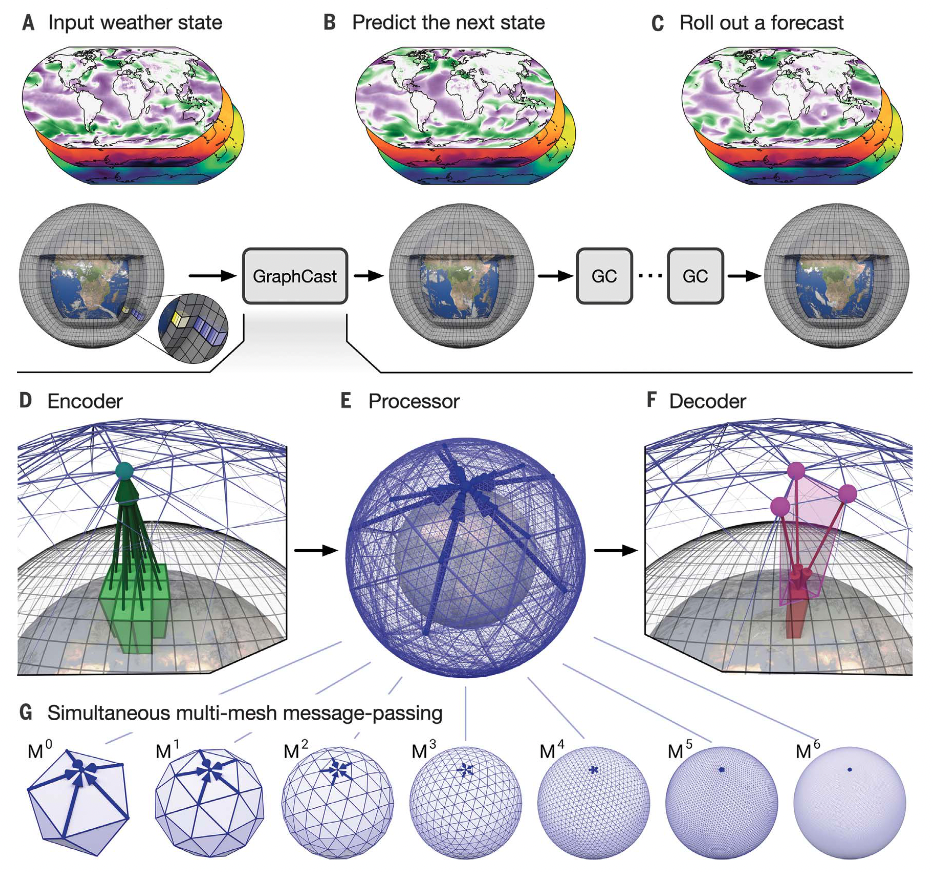

Lam, Remi, et al. "Learning skillful medium-range global weather forecasting." Science 382.6677 (2023): 1416-1421.

## **Represent graph structured data**

### **General**

Graphs are set of nodes and edges indicating their connection.

Case 1:

All nodes are identical

All edges are identical

In [ ]:
# Routine to draw graph structure
def draw_graph_structure(adjacency_matrix, color=None):

    G = nx.Graph()
    n_node = adjacency_matrix.shape[0]
    for i in range(n_node):
      for j in range(i):
        if adjacency_matrix[i,j]:
            G.add_edge(i,j)

    if color is None:
        nx.draw(G, nx.spring_layout(G, seed = 0), with_labels=True)
    else:
        nx.draw(G, nx.spring_layout(G, seed = 0), with_labels=True, node_color=color)
    plt.show()

[[0 1 0 1 0 0 0 0]
 [1 0 1 1 1 0 0 0]
 [0 1 0 0 1 0 0 0]
 [1 1 0 0 1 0 0 0]
 [0 1 1 1 0 1 0 1]
 [0 0 0 0 1 0 1 1]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 0 0]]


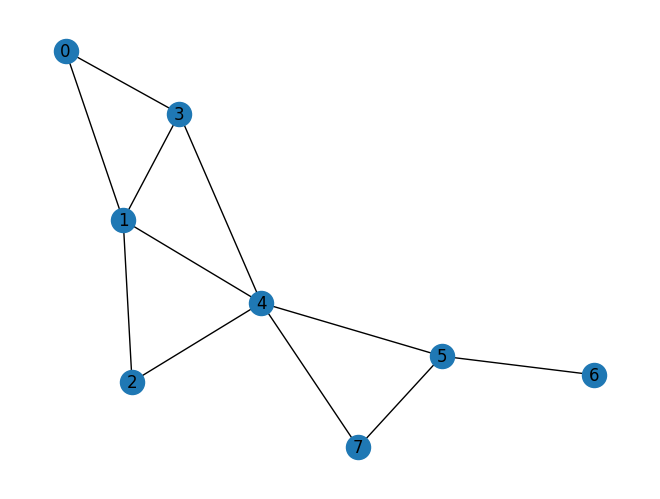

In [ ]:
# An adjacency matrix define a graph
# A (adjacency matrix) of shape (num_nodes, num_nodes)
A = np.array([[0,1,0,1,0,0,0,0],
              [1,0,1,1,1,0,0,0],
              [0,1,0,0,1,0,0,0],
              [1,1,0,0,1,0,0,0],
              [0,1,1,1,0,1,0,1],
              [0,0,0,0,1,0,1,1],
              [0,0,0,0,0,1,0,0],
              [0,0,0,0,1,1,0,0]]);
print(A)
draw_graph_structure(A)

Case 2:

Nodes are not identical

All edges are identical

[[1]
 [0]
 [1]
 [2]
 [2]
 [0]
 [1]
 [1]]
[[0 1 0 1 0 0 0 0]
 [1 0 1 1 1 0 0 0]
 [0 1 0 0 1 0 0 0]
 [1 1 0 0 1 0 0 0]
 [0 1 1 1 0 1 0 1]
 [0 0 0 0 1 0 1 1]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 0 0]]


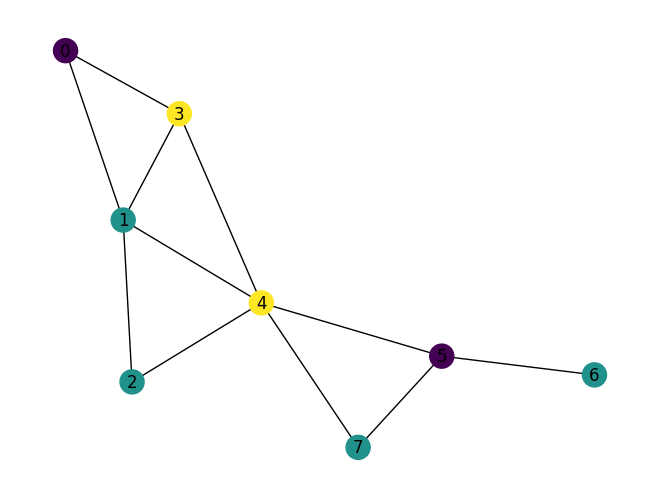

In [ ]:
# Node features and adjacency matrix define a graph
# A (adjacency matrix) of shape (num_nodes, num_nodes)
# H (Node features matrix) of shape (num_nodes, dim_nodes)
A = np.array([[0,1,0,1,0,0,0,0],
              [1,0,1,1,1,0,0,0],
              [0,1,0,0,1,0,0,0],
              [1,1,0,0,1,0,0,0],
              [0,1,1,1,0,1,0,1],
              [0,0,0,0,1,0,1,1],
              [0,0,0,0,0,1,0,0],
              [0,0,0,0,1,1,0,0]])

H = np.array([
    [1],
    [0],
    [1],
    [2],
    [2],
    [0],
    [1],
    [1]
])
print(H)
print(A)
draw_graph_structure(A, color=H)

Case 3:

Nodes are not identical

Edges are not identical

In [ ]:
# An adjacency matrix define a graph
# A (adjacency matrix) of shape (num_nodes, num_nodes)
# H (Node features matrix) of shape (num_nodes, dim_nodes)
# E (Edge features tensor) of shape (num_nodes, num_nodes, dim_edges)
A = np.array([[0,1,0,1,0,0,0,0],
              [1,0,1,1,1,0,0,0],
              [0,1,0,0,1,0,0,0],
              [1,1,0,0,1,0,0,0],
              [0,1,1,1,0,1,0,1],
              [0,0,0,0,1,0,1,1],
              [0,0,0,0,0,1,0,0],
              [0,0,0,0,1,1,0,0]])

H = np.array([
    [1],
    [0],
    [1],
    [2],
    [2],
    [0],
    [1],
    [1]
])
E = np.zeros((H.shape[0], H.shape[0], 2))
for i in range(H.shape[0]):
    for j in range(H.shape[0]):
        if A[i, j] == 1:
            E[i, j, 0] = H[i, 0]
            E[i, j, 1] = H[j, 0]

print(f"Adjacency matrix: \n{A}")
print(f"Node features matrix: \n{H}")
print(f"Edge features tensor: \n{E}")

Adjacency matrix: 
[[0 1 0 1 0 0 0 0]
 [1 0 1 1 1 0 0 0]
 [0 1 0 0 1 0 0 0]
 [1 1 0 0 1 0 0 0]
 [0 1 1 1 0 1 0 1]
 [0 0 0 0 1 0 1 1]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 0 0]]
Node features matrix: 
[[1]
 [0]
 [1]
 [2]
 [2]
 [0]
 [1]
 [1]]
Edge features tensor: 
[[[0. 0.]
  [1. 0.]
  [0. 0.]
  [1. 2.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 1.]
  [0. 0.]
  [0. 1.]
  [0. 2.]
  [0. 2.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [1. 0.]
  [0. 0.]
  [0. 0.]
  [1. 2.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[2. 1.]
  [2. 0.]
  [0. 0.]
  [0. 0.]
  [2. 2.]
  [0. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [2. 0.]
  [2. 1.]
  [2. 2.]
  [0. 0.]
  [2. 0.]
  [0. 0.]
  [2. 1.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 2.]
  [0. 0.]
  [0. 1.]
  [0. 1.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [1. 0.]
  [0. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 0.]
  [0. 0.]
  [0. 0.]
  [1. 2.]
  [1. 0.]
  [0. 0.]
  [0. 0.]]]


### **PyTorch Geometric**

You can directly work with the torch tensor with PyTorch and build a network, but there are packages that makes it easier. A popular one is PyTorch Geometric. A single graph is handeled by an instance of [torch_geometric.data.Data](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data) in PyG.

A graph data in PyG can be seen as a dictionary with different attributes as keys and corresponding tensors as values. By default, a graph has following attributes:

*   data.x: Node feature matrix with shape [num_nodes, num_node_features]
*   data.edge_index: Graph connectivity in [COO](https://pytorch.org/docs/stable/sparse.html#sparse-coo-docs) format with shape [2, num_edges]
*   data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
*   data.y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]
*   data.pos: Node position matrix with shape [num_nodes, num_dimensions]

In [ ]:
from torch_geometric.data import Data

# define node features
x = torch.tensor([[-1], [0], [1]])

# define edge list
edge_index = torch.tensor(
    [[0, 1, 1, 2],
     [1, 0, 2, 1]])

# A = [
#     [0, 1, 0],
#     [1, 0, 1],
#     [0, 1, 0],
# ]

# create graph data object
data = Data(x=x, edge_index=edge_index)
print(data)

Data(x=[3, 1], edge_index=[2, 4])


In [ ]:
for key, item in data:
    print(f'{key} found in data: {item}')

x found in data: tensor([[-1],
        [ 0],
        [ 1]])
edge_index found in data: tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])


In [ ]:
# create graph data object
data = Data()

# define edge list
data.edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]])

# define node features
data.x = torch.tensor([[-1], [0], [1]])

print(data)

Data(edge_index=[2, 4], x=[3, 1])


In [ ]:
for key, item in data:
    print(f'{key} found in data: {item}')

edge_index found in data: tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])
x found in data: tensor([[-1],
        [ 0],
        [ 1]])


Besides holding a number of node-level, edge-level or graph-level attributes, Data provides a number of useful utility functions:

In [ ]:
# Check what attributes
print(data.keys())

['x', 'edge_index']


In [ ]:
# check number of edges of the graph
print(data.num_edges)

4


In [ ]:
# check number of nodes of the graph
print(data.num_nodes)

3


In [ ]:
# check number of features of the graph
print(data.num_features)

1


In [ ]:
# check if there are edge features in the graph
'edge_attr' in data

False

In [ ]:
# check if graph is directed
print(data.is_directed())

False


In [ ]:
# fetch the internal data
data['x'], data['edge_index']

(tensor([[-1],
         [ 0],
         [ 1]]),
 tensor([[0, 1, 1, 2],
         [1, 0, 2, 1]]))

In [ ]:
# fetch the internal data
data.x, data.edge_index

(tensor([[-1],
         [ 0],
         [ 1]]),
 tensor([[0, 1, 1, 2],
         [1, 0, 2, 1]]))

In [ ]:
# You can transfer all matrice together to GPU
data.to(device)
data.x, data.edge_index

(tensor([[-1],
         [ 0],
         [ 1]], device='cuda:0'),
 tensor([[0, 1, 1, 2],
         [1, 0, 2, 1]], device='cuda:0'))

In [ ]:
# You can add any label to the graph data
data.special = 'something'
data.another = torch.randn(data.num_nodes, 2)
data

Data(edge_index=[2, 4], x=[3, 1], special='something', another=[3, 2])

In [ ]:
# Internal data within a graph data can be on different devices
data.x, data.edge_index, data.special, data.another

(tensor([[-1],
         [ 0],
         [ 1]], device='cuda:0'),
 tensor([[0, 1, 1, 2],
         [1, 0, 2, 1]], device='cuda:0'),
 'something',
 tensor([[ 1.5534, -1.3468],
         [ 0.0641, -1.9848],
         [ 0.0031, -0.5764]]))

In [ ]:
data.to(device)
data.x, data.edge_index, data.special, data.another

(tensor([[-1],
         [ 0],
         [ 1]], device='cuda:0'),
 tensor([[0, 1, 1, 2],
         [1, 0, 2, 1]], device='cuda:0'),
 'something',
 tensor([[ 1.5534, -1.3468],
         [ 0.0641, -1.9848],
         [ 0.0031, -0.5764]], device='cuda:0'))

### **Batching graphs**

Neural networks are usually trained in a batch-wise fashion. PyG achieves parallelization over a mini-batch by creating sparse block diagonal adjacency matrices (defined by edge_index) and concatenating feature and target matrices in the node dimension.

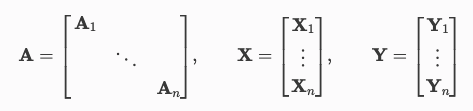

PyG has its own torch_geometric.loader.DataLoader, which already takes care of this concatenation process. It is similar to the DataLoader in PyTorch but has a collocater function for graphs.

In [ ]:
from torch_geometric.loader import DataLoader

g = Data(x=torch.randn(3, 4), edge_index=torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]]))
loader = DataLoader([g] * 32, batch_size=4, shuffle=True)

batch = next(iter(loader))

print(g)
print(batch)

Data(x=[3, 4], edge_index=[2, 4])
DataBatch(x=[12, 4], edge_index=[2, 16], batch=[12], ptr=[5])


In [ ]:
print(g.x)
print(batch.x)

tensor([[ 0.1795,  1.5049,  0.0150, -1.8900],
        [ 0.4047,  0.8877,  1.4871,  0.9022],
        [ 2.6313, -1.5322,  1.6228,  0.9252]])
tensor([[ 0.1795,  1.5049,  0.0150, -1.8900],
        [ 0.4047,  0.8877,  1.4871,  0.9022],
        [ 2.6313, -1.5322,  1.6228,  0.9252],
        [ 0.1795,  1.5049,  0.0150, -1.8900],
        [ 0.4047,  0.8877,  1.4871,  0.9022],
        [ 2.6313, -1.5322,  1.6228,  0.9252],
        [ 0.1795,  1.5049,  0.0150, -1.8900],
        [ 0.4047,  0.8877,  1.4871,  0.9022],
        [ 2.6313, -1.5322,  1.6228,  0.9252],
        [ 0.1795,  1.5049,  0.0150, -1.8900],
        [ 0.4047,  0.8877,  1.4871,  0.9022],
        [ 2.6313, -1.5322,  1.6228,  0.9252]])


In [ ]:
print(g.edge_index)
print(batch.edge_index)

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])
tensor([[ 0,  1,  1,  2,  3,  4,  4,  5,  6,  7,  7,  8,  9, 10, 10, 11],
        [ 1,  0,  2,  1,  4,  3,  5,  4,  7,  6,  8,  7, 10,  9, 11, 10]])


In [ ]:
# Batch is a column vector which maps each node to its respective graph in the batch
batch.batch

tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3])

In [ ]:
# A monotonically increasing pointer tensor that refers to the boundaries of segments
batch.ptr

tensor([ 0,  3,  6,  9, 12])

### **Datasets**

PyG contains a large number of common benchmark datasets. An initialization of a dataset will automatically download its raw files and process them to the previously described Data format.

Let's look at a real-world graph dataset and see how we can build a machine learning model to solve model it:

In [ ]:
from torch_geometric.datasets import MoleculeNet

# ESOL is a water solubility prediction dataset consisting of 1128 samples: https://moleculenet.org/datasets-1
dataset = MoleculeNet(root='tmp/ESOL', name='ESOL')

Processing...
Done!


In [ ]:
# number of graphs
print("Number of graphs: ", len(dataset))

# number of features
print("Number of features: ", dataset.num_features)

# number of classes
print("Number of classes: ", dataset.num_classes)

Number of graphs:  1128
Number of features:  9
Number of classes:  734


/usr/local/lib/python3.11/dist-packages/torch_geometric/data/dataset.py:169: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  warnings.warn("Found floating-point labels while calling "


In [ ]:
# select the first graph
data = dataset[0]

# number of nodes
print("Number of nodes: ", data.num_nodes)

# number of edges
print("Number of edges: ", data.num_edges)

# check if directed
print("Is directed: ", data.is_directed())

Number of nodes:  32
Number of edges:  68
Is directed:  False


In [ ]:
data

Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])

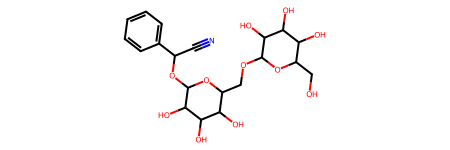

In [ ]:
from rdkit import Chem

Chem.MolFromSmiles(data.smiles)

In [ ]:
data.x

tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 

In [ ]:
data.edge_attr

tensor([[ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 3,  0,  0],
        [ 3,  0,  0],
        [ 1,  0,  0],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  0],
        [ 

In [ ]:
data.y

tensor([[-0.7700]])

In [ ]:
train_dataset = dataset[:800]
test_dataset = dataset[800:]

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
data_batch = next(iter(train_loader))
print(data_batch)

DataBatch(x=[1710, 9], edge_index=[2, 3530], edge_attr=[3530, 3], smiles=[128], y=[128, 1], batch=[1710], ptr=[129])


In [ ]:
data_batch.batch

tensor([  0,   0,   0,  ..., 127, 127, 127])

## **Graph neural network (GNN) -- Learning on graph data**

In [ ]:
# Quiz
# What is the difference between a CNN and an MLP?

### **What's special about graphs -- Permutation invariance and interaction between nodes**

Modern deep learning methods are designed for simple sequences and grids.

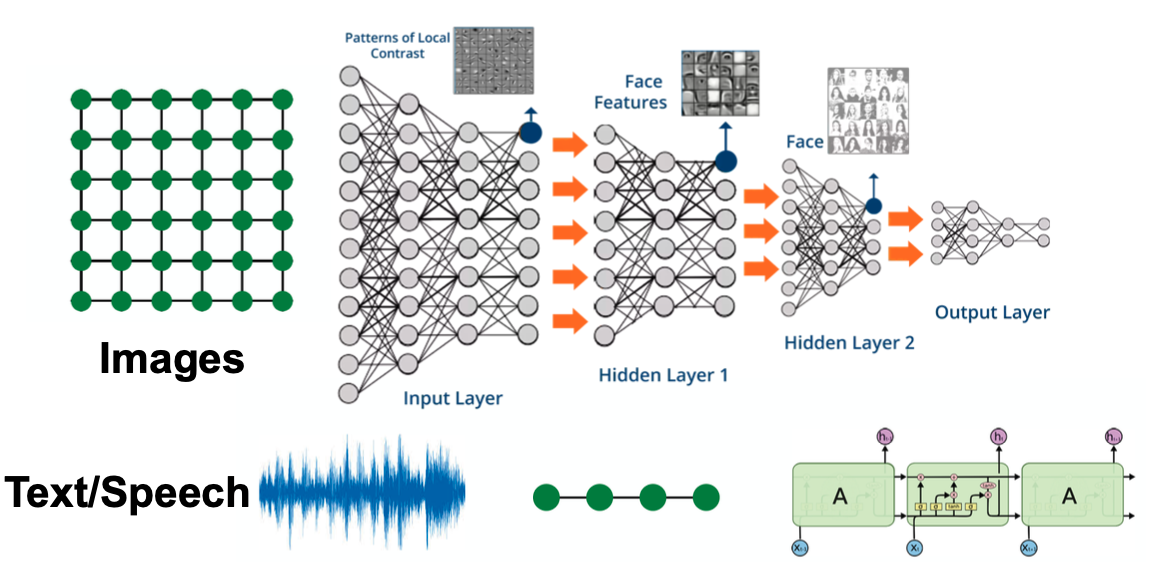

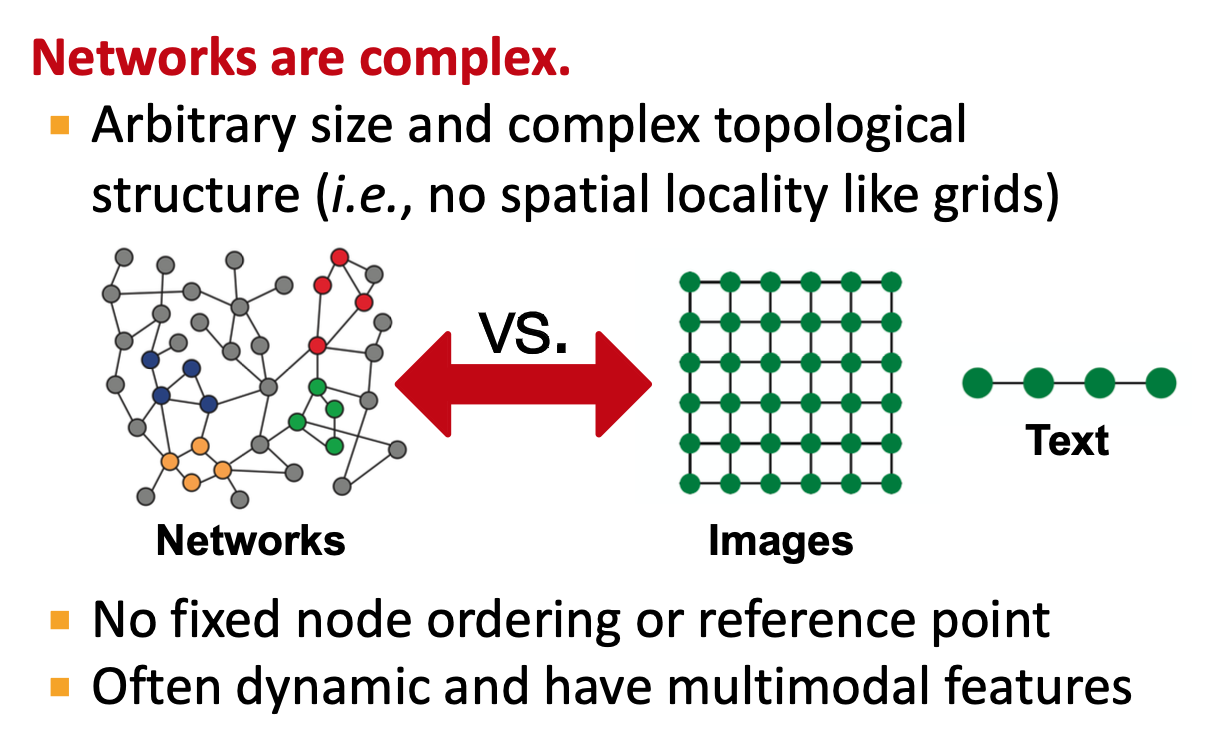

For graphs, we need to handle the permutation invariance and the topological structure indicated by the connectivity.

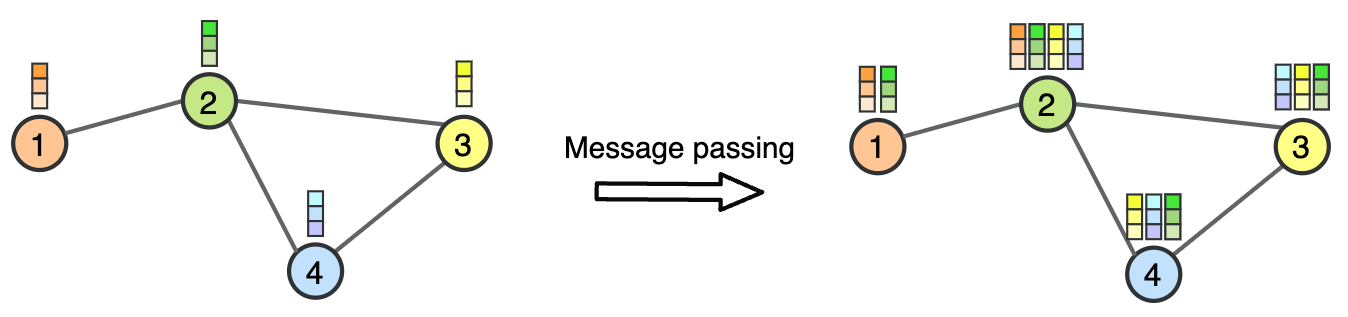

Neural networks specially designed for different data type:

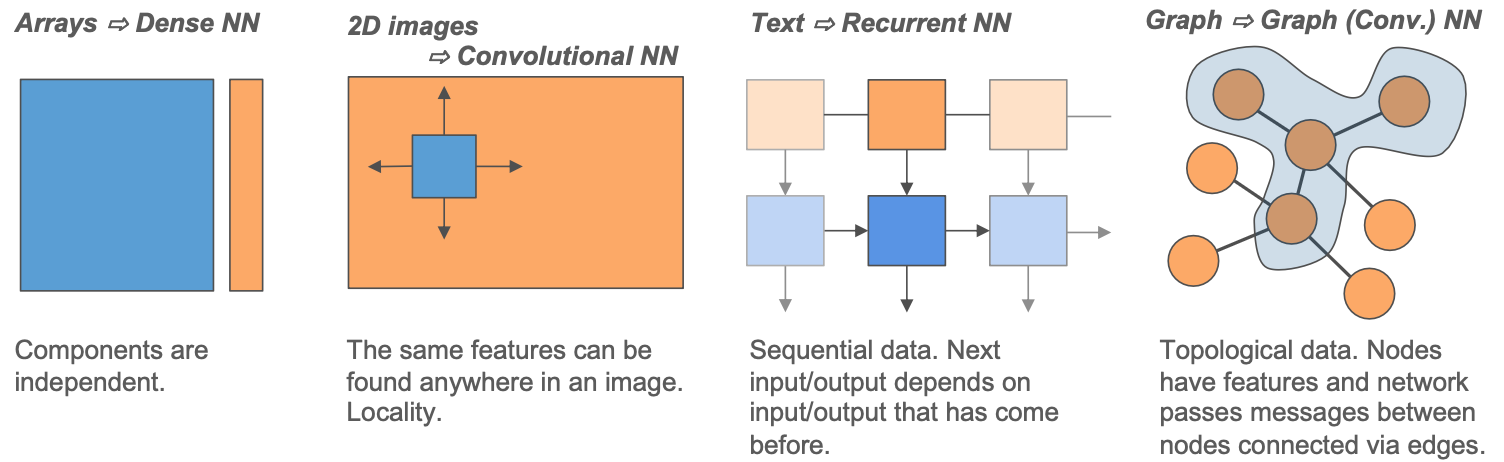

### **Typical GNN Model**

Bronstein, Michael M., et al. "Geometric deep learning: Grids, groups, graphs, geodesics, and gauges." arXiv preprint arXiv:2104.13478 (2021).

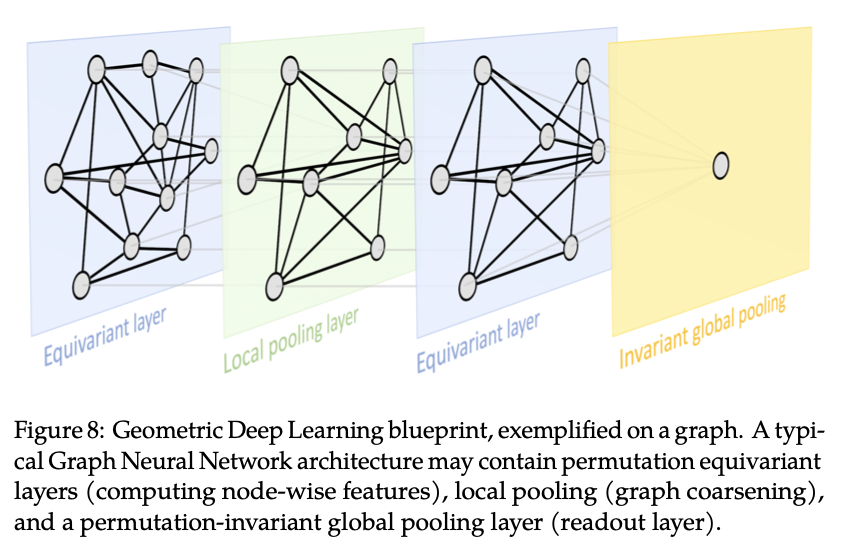

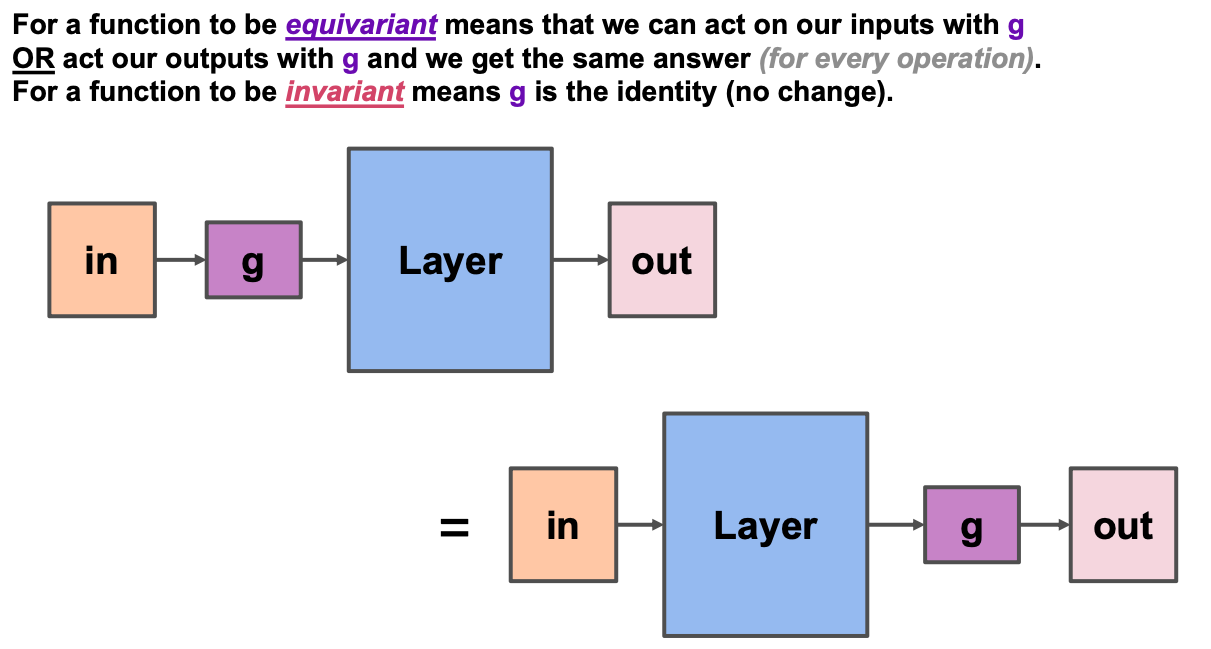

# Equivariance & Invariance in Graph Neural Networks


- **Equivariance**:  
$$
\
\mathrm{Layer}(g \cdot \mathrm{in}) = g \cdot \mathrm{Layer}(\mathrm{in})
\
$$
If we **transform the input** with \( g \), and then apply the layer, it's the same as applying the layer first and then transforming the **output**.

- **Invariance**:  
$$
\
\mathrm{Layer}(g \cdot \mathrm{in}) = \mathrm{Layer}(\mathrm{in})
\
$$  
If we **transform the input** with \( g \), the output **doesn't change** — it stays the same.



In GNNs, we care a lot about how the **structure or ordering of a graph** affects the results.


## 🕸️ GNN Example: Social Network

Imagine 3 friends in a group chat:
- Alice 👩
- Bob 👨
- Carol 👩‍🦰

Each has a profile (age, interests, etc.). A GNN processes their connections to predict **influence score**.

**Permutation Equivariance**:
- If we swap the *order* of Alice and Carol in the input, the GNN will still compute the right influence scores — just in the swapped order.
- Output changes predictably when input changes.

**Permutation Invariance**:
- Suppose we want to predict whether this **group** is likely to go viral (a group-level output).
- It shouldn’t matter if Alice is listed first or Carol — the output (yes/no) stays the same.





### **Graph convolution Network**

Let's begin with one of the most simple GNN operators, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)). The graph convolution operation is defined as:

$$
\mathbf{x}^{\prime}_i = \mathbf{\Theta}^{\top} \sum_{j \in
\mathcal{N}(i) \cup \{ i \}} \frac{e_{j,i}}{\sqrt{\hat{d}_j
\hat{d}_i}} \mathbf{x}_j
$$

with $\hat{d}_i = 1 + \sum_{j \in \mathcal{N}(i)} e_{j,i}$, where $e_{j,i}$ denotes the edge weight from source node $j$ to target node $i$.

The matrix form is:

$$
\mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
\mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta}
$$

where $\mathbf{\hat{A}} = \mathbf{A} + \mathbf{I}$ denotes the adjacency matrix with inserted self-loops and $\hat{D}_{ii} = \sum_{j=0} \hat{A}_{ij}$ its diagonal degree matrix. $e_{j,i} = \mathcal{A}_{ij}$ indicates the adjacency matrix can include other values than $1$ representing edge weights.

Now consider a simple case, all edges are identical and only consider neighbor nodes:

$$
\mathbf{X}^{\prime} = \mathbf{A} \mathbf{X} \mathbf{\Theta}
$$

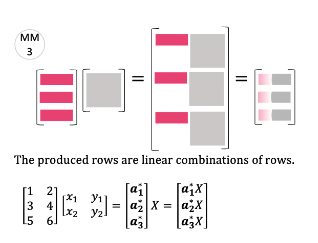

(Figure from https://github.com/kenjihiranabe/The-Art-of-Linear-Algebra/blob/main/The-Art-of-Linear-Algebra.pdf)

In [ ]:
class Our_GCNLayer(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    Implementation is referenced https://github.com/tkipf/pygcn/tree/master
    """

    def __init__(self, input_dim, output_dim, bias=True):
        """
        A graph convolution layer.

        Args:
          input_dim: Input feature dimension
          output_dim: Output feature dimension
          bias: Whether to include bias term
        """
        super(Our_GCNLayer, self).__init__()

        self.lin = nn.Linear(input_dim, output_dim, bias=False)

        if bias:
            self.bias = nn.Parameter(torch.rand(output_dim))
        else:
            self.register_parameter('bias', None)

    def forward(self, x, adj_pyg):
        """
        Args:
          x: Node feature matrix of shape [num_nodes, input_dim]
          adj_pyg: Adjacency matrix of shape in COO sparse format [2, num_edges]
        """

        support = self.lin(x)

        adj = torch.sparse_coo_tensor(adj_pyg, torch.ones(adj_pyg.shape[1]), [x.shape[0], x.shape[0]])
        output = torch.spmm(adj, support)

        if self.bias is not None:
            return output + self.bias
        else:
            return output

In [ ]:
data

Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])

In [ ]:
gcn_layer = Our_GCNLayer(input_dim=9, output_dim=16)
gcn_layer

Our_GCNLayer(
  (lin): Linear(in_features=9, out_features=16, bias=False)
)

In [ ]:
test_node_feature = torch.randn(3, 9)
test_adj_matrix = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]])
test_node_feature, test_adj_matrix

(tensor([[-0.0793, -3.0170,  0.1877, -0.3663, -0.4181, -0.6570, -0.6059, -0.6848,
           0.2367],
         [ 0.2218,  1.2462,  0.2689,  0.4564,  0.3501, -0.0674, -2.5366,  0.1815,
           0.7265],
         [-0.6029, -0.7544,  0.8665,  0.5409,  0.4787,  0.6082, -0.1292, -2.3209,
           0.3282]]),
 tensor([[0, 1, 1, 2],
         [1, 0, 2, 1]]))

In [ ]:
gcn_layer(test_node_feature, test_adj_matrix)

tensor([[-0.3494,  0.7764, -0.5590,  0.4683,  1.5573,  0.7876,  0.6624,  0.7952,
          0.1686,  0.4541,  1.0565,  1.0623,  1.0236,  1.2990,  0.8791,  0.0054],
        [-0.2557,  0.5228,  1.1358, -1.7422,  0.3099,  0.9010,  0.4185,  2.2690,
         -0.2362,  1.2816,  0.2462,  2.2183, -1.1020,  0.7691,  2.2443,  0.3834],
        [-0.3494,  0.7764, -0.5590,  0.4683,  1.5573,  0.7876,  0.6624,  0.7952,
          0.1686,  0.4541,  1.0565,  1.0623,  1.0236,  1.2990,  0.8791,  0.0054]],
       grad_fn=<AddBackward0>)

In [ ]:
gcn_layer(test_node_feature, test_adj_matrix).shape

torch.Size([3, 16])

### **Information aggregation / graph pooling**

Following the equivariant layers, we will have learned embeddings for nodes (and edges). To perform graph-level prediction tasks, we need a invariant operation to aggregate the information, which is called graph pooling.

Literatures demonstrate that the choice of aggregation functions contributes significantly to the representational power and performance of the model. For example, **mean aggregation** captures the distribution (or proportions) of elements, **max aggregation** proves to be advantageous to identify representative elements, and **sum aggregation** enables the learning of structural graph properties ([Xu et al. (2018)](https://arxiv.org/abs/1810.00826)).

Now, let's implement a sum aggregation function:

In [ ]:
def our_add_pool(x, batch=None):

    if batch is None:
        return x.sum(dim=0, keepdim=True)
    else:
        # For simplicity, let's work with single graph only.
        pass

In [ ]:
x_test = torch.randn(2, 3)
x_test

tensor([[ 0.5627,  0.3411,  0.4192],
        [ 1.0923, -0.2283,  0.6123]])

In [ ]:
our_add_pool(x_test)

tensor([[1.6550, 0.1128, 1.0315]])

### **Build the network**

In [ ]:
from torch_geometric.nn import MLP

class GCN_torch(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(GCN_torch, self).__init__()
        """ GCNConv layers """

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(Our_GCNLayer(in_channels, hidden_channels))
            in_channels = hidden_channels

        self.readout = MLP([hidden_channels, hidden_channels, out_channels], norm=None, dropout=0.5)

    def forward(self, data):

        x, edge_index, batch = data.x.to(torch.float), data.edge_index, data.batch

        for conv in self.convs:
            x = conv(x, edge_index).relu()

        return self.readout(our_add_pool(x, batch))

In [ ]:
data

Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])

In [ ]:
gcn_torch = GCN_torch(in_channels=9, hidden_channels=16, out_channels=1, num_layers=2)
gcn_torch

GCN_torch(
  (convs): ModuleList(
    (0): Our_GCNLayer(
      (lin): Linear(in_features=9, out_features=16, bias=False)
    )
    (1): Our_GCNLayer(
      (lin): Linear(in_features=16, out_features=16, bias=False)
    )
  )
  (readout): MLP(16, 16, 1)
)

In [ ]:
gcn_torch(data)

tensor([[-8.2865]], grad_fn=<AddmmBackward0>)

Up to now, we just use PyTorch to build the network. PyG implements this layer via [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), which can be executed by passing in the node feature representation `x` and the COO graph connectivity representation `edge_index`. PyG also provide various aggregation function, including sum pooling by [`global_add_pool`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.pool.global_add_pool.html#torch_geometric.nn.pool.global_add_pool).

With this, we are able to create the network by calling the predefined layers and functions:

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(GCN, self).__init__()
        """ GCNConv layers """

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(GCNConv(in_channels, hidden_channels, normalize=False))
            in_channels = hidden_channels

        self.readout = MLP([hidden_channels, hidden_channels, out_channels], norm=None, dropout=0.5)

    def forward(self, data):

        x, edge_index, batch = data.x.to(torch.float), data.edge_index, data.batch

        for conv in self.convs:
            x = conv(x, edge_index).relu()

        return self.readout(global_add_pool(x, batch))

In [ ]:
gcn_pyg = GCN(in_channels=9, hidden_channels=16, out_channels=1, num_layers=2)
gcn_pyg

GCN(
  (convs): ModuleList(
    (0): GCNConv(9, 16)
    (1): GCNConv(16, 16)
  )
  (readout): MLP(16, 16, 1)
)

In [ ]:
gcn_pyg(data)

tensor([[111.5447]], grad_fn=<AddmmBackward0>)

In [ ]:
for name, param in gcn_pyg.named_parameters():
    print(name, param.data)

convs.0.bias tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
convs.0.lin.weight tensor([[ 0.3032, -0.0015,  0.0737,  0.2282, -0.4899,  0.4463,  0.2462,  0.0261,
         -0.3707],
        [ 0.2854,  0.1112, -0.4389,  0.2305,  0.4628,  0.4095, -0.4635, -0.0477,
          0.1198],
        [ 0.2341, -0.1796, -0.0556, -0.1614, -0.4624,  0.1223, -0.2055,  0.0509,
          0.4679],
        [-0.1608,  0.1551, -0.3289, -0.0525, -0.0078,  0.0384,  0.4667, -0.3458,
         -0.3152],
        [-0.0474,  0.2636,  0.0018,  0.4883,  0.0708,  0.3491,  0.0679,  0.4421,
         -0.3574],
        [ 0.4046, -0.3555, -0.2594,  0.1106,  0.4552,  0.1243, -0.1592, -0.3724,
         -0.1455],
        [ 0.3279,  0.1162,  0.0835, -0.3277,  0.3484,  0.1088,  0.2989, -0.4521,
         -0.0007],
        [ 0.0742, -0.4333, -0.4068,  0.4755, -0.4684, -0.4096,  0.4502,  0.3984,
         -0.1142],
        [-0.4285, -0.2517,  0.2996,  0.3616,  0.0582, -0.0622, -0.1616, -0.3237,
          0.40

In [ ]:
for name, param in gcn_torch.named_parameters():
    print(name, param.data)

convs.0.bias tensor([0.0309, 0.6204, 0.6376, 0.4599, 0.4880, 0.7510, 0.4628, 0.1872, 0.5292,
        0.8466, 0.3359, 0.2872, 0.4172, 0.6722, 0.2330, 0.3636])
convs.0.lin.weight tensor([[ 0.2322, -0.0817, -0.2765, -0.0161,  0.3100,  0.2509, -0.2489, -0.0306,
          0.3108],
        [-0.3242,  0.2508,  0.0598,  0.1297, -0.0885,  0.2129,  0.0807,  0.1018,
          0.3130],
        [-0.0087, -0.2251,  0.0143,  0.1983,  0.0503, -0.2957, -0.2932,  0.1895,
         -0.1956],
        [ 0.1832,  0.1278, -0.1345, -0.2723,  0.3322, -0.1645, -0.0911,  0.2237,
         -0.0310],
        [-0.0352, -0.1327,  0.1928, -0.1905,  0.3034, -0.3168,  0.0017,  0.1815,
         -0.0799],
        [ 0.0656,  0.1240, -0.0617,  0.0918, -0.2233,  0.0932, -0.0084,  0.0908,
         -0.1899],
        [-0.0101,  0.2743,  0.3025,  0.2424, -0.2237,  0.0933, -0.0021,  0.1234,
         -0.2149],
        [ 0.1297, -0.2403, -0.0850, -0.2867,  0.0792,  0.1944, -0.0955, -0.2512,
         -0.2885],
        [-0.1764,  0.30

We can verify these two are identical by copying the parameters:

In [ ]:
gcn_pyg.load_state_dict(gcn_torch.state_dict())
gcn_pyg.eval()
gcn_torch.eval()
gcn_pyg(data), gcn_torch(data)

(tensor([[-9.4365]], grad_fn=<AddmmBackward0>),
 tensor([[-9.4365]], grad_fn=<AddmmBackward0>))

### **Training a GNN**

In [ ]:
# Quiz
# How did you train a network in PyTorch?

```
# Define our model
model = MyNeuralNetwork(...)

# Choose our optimizer
optimizer = torch.optim.SGD(
  model.parameters(), lr=0.01, momentum=0.9
)

for epoch in range(num_epochs):
    # Loop over a DataLoader
    for batch_idx, batch in enumerate(train_loader):

        # Unpack the data
        features, targets = batch

        # Zero the gradients for every batch
        optimizer.zero_grad()
            
        # Make predictions for this batch
        forward_pass_outputs = model(features)

        # Compute the loss and its gradients
        loss = loss_fn(forward_pass_outputs, targets)

        # Compute the gradients via back propagation
        loss.backward()
        
        # Updates the weights through optimization
        optimizer.step()

```

Training a GNN is the same in PyTorch/PyG

In [ ]:
epochs = 50
hidden_channels = 64
num_layers = 5
lr = 0.0005

model = GCN(in_channels=9, hidden_channels=hidden_channels, out_channels=1, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loss_list = []
val_lost_list = []

for epcoh in range(1, epochs + 1):
        # Train
        model.train()
        for data_minibatch in train_loader:
                data_minibatch = data_minibatch.to(device)
                optimizer.zero_grad()
                out = model(data_minibatch)
                loss = F.l1_loss(out, data_minibatch.y)
                loss.backward()
                optimizer.step()

        # Evaluate on training set
        model.eval()
        total_loss_train = 0
        for data_minibatch in train_loader:
                data_minibatch = data_minibatch.to(device)
                pred = model(data_minibatch)
                loss = F.l1_loss(pred, data_minibatch.y)
                total_loss_train += float(loss) * data_minibatch.num_graphs

        # Evaluate on test set
        model.eval()
        total_loss_test = 0
        for data_minibatch in test_loader:
                data_minibatch = data_minibatch.to(device)
                pred = model(data_minibatch)
                loss = F.l1_loss(pred, data_minibatch.y)
                total_loss_test += float(loss) * data_minibatch.num_graphs

        total_loss_train = total_loss_train / len(train_dataset)
        total_loss_test = total_loss_test / len(test_dataset)

        train_loss_list.append(total_loss_train)
        val_lost_list.append(total_loss_test)

        print(f'Epoch: {epcoh:03d}, Train MAE: {total_loss_train:.4f}, Test MAE: {total_loss_test:.4f}')

Epoch: 001, Train MAE: 2.3123, Test MAE: 2.4104
Epoch: 002, Train MAE: 3.2138, Test MAE: 2.9789
Epoch: 003, Train MAE: 2.7610, Test MAE: 2.7085
Epoch: 004, Train MAE: 2.3944, Test MAE: 2.4158
Epoch: 005, Train MAE: 1.9390, Test MAE: 2.0405
Epoch: 006, Train MAE: 1.5123, Test MAE: 1.6307
Epoch: 007, Train MAE: 1.4076, Test MAE: 1.5272
Epoch: 008, Train MAE: 1.1961, Test MAE: 1.2668
Epoch: 009, Train MAE: 1.1646, Test MAE: 1.2290
Epoch: 010, Train MAE: 1.1315, Test MAE: 1.1992
Epoch: 011, Train MAE: 1.1782, Test MAE: 1.2279
Epoch: 012, Train MAE: 1.2017, Test MAE: 1.2743
Epoch: 013, Train MAE: 1.1632, Test MAE: 1.2115
Epoch: 014, Train MAE: 1.1367, Test MAE: 1.1955
Epoch: 015, Train MAE: 1.0447, Test MAE: 1.0827
Epoch: 016, Train MAE: 1.0944, Test MAE: 1.1593
Epoch: 017, Train MAE: 1.0215, Test MAE: 1.0623
Epoch: 018, Train MAE: 1.0308, Test MAE: 1.0932
Epoch: 019, Train MAE: 1.0375, Test MAE: 1.1159
Epoch: 020, Train MAE: 1.0855, Test MAE: 1.1701
Epoch: 021, Train MAE: 1.0898, Test MAE:

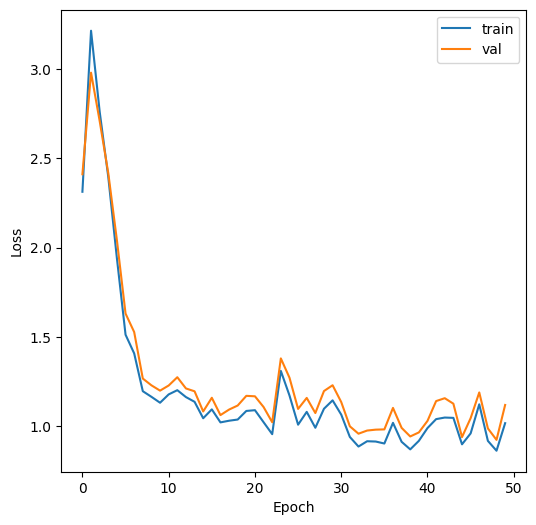

In [ ]:
# Plot learning curve
plt.figure(figsize=(6, 6))
plt.plot(train_loss_list, label='train')
plt.plot(val_lost_list, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

RMSE =  1.3494378
R^2 =  0.5958711


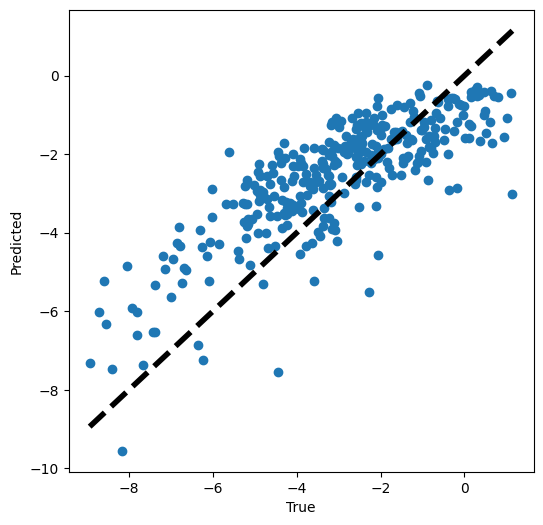

In [ ]:
y_true = []
y_pred = []
for data_minibatch in test_loader:
        data_minibatch = data_minibatch.to(device)
        pred = model(data_minibatch)
        y_true.append(data_minibatch.y.cpu().detach().numpy())
        y_pred.append(pred.cpu().detach().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

RMSE = np.sqrt(np.mean((y_true - y_pred)**2))
print('RMSE = ', RMSE)

R_square = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
print('R^2 = ', R_square)

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

### **Graph Attention Network (GAT)**

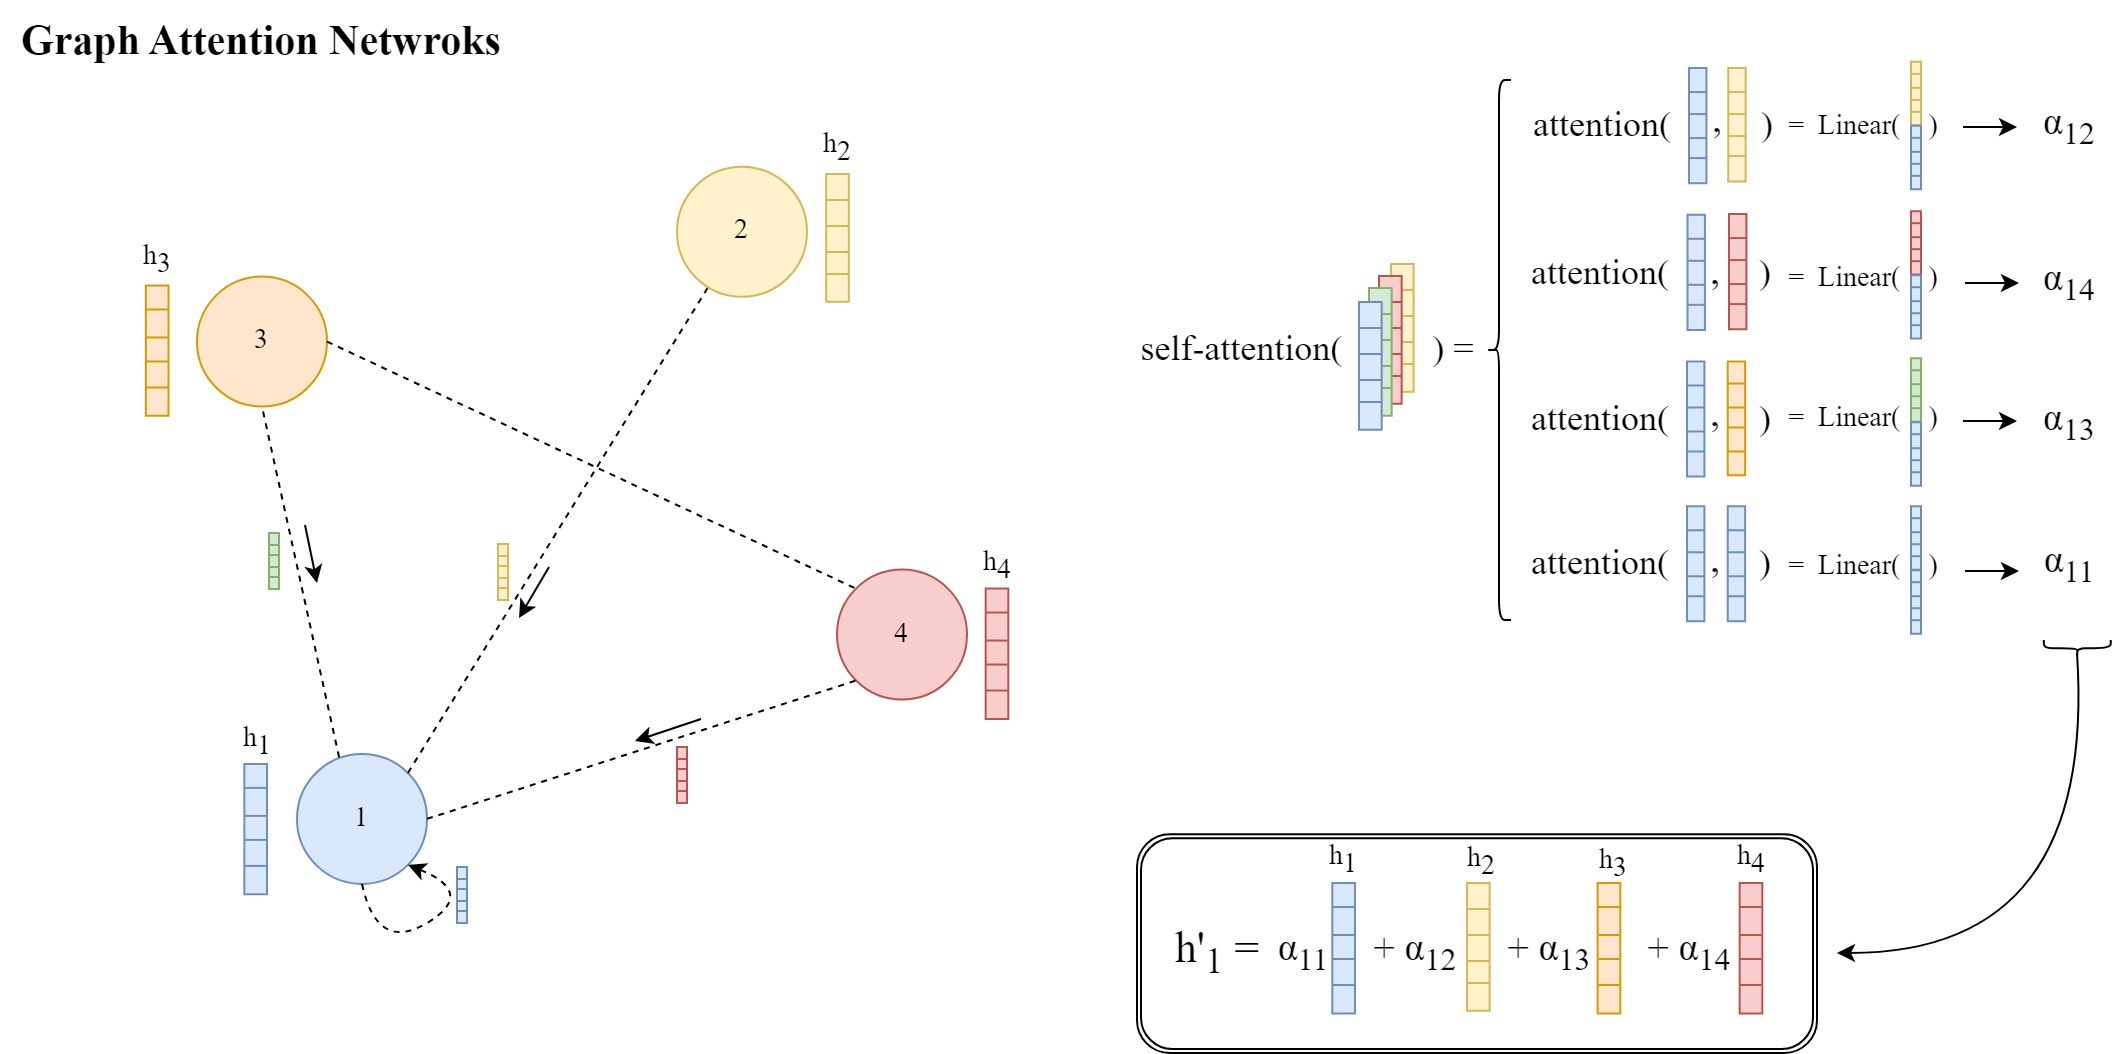

1. Veličković, Petar, et al. "Graph attention networks." arXiv preprint arXiv:1710.10903 (2017)
2. Brody, Shaked, Uri Alon, and Eran Yahav. "How attentive are graph attention networks?." arXiv preprint arXiv:2105.14491 (2021).

Excellent Blog Post on Graph Attention Networks(https://epichka.com/blog/2023/gat-paper-explained/)

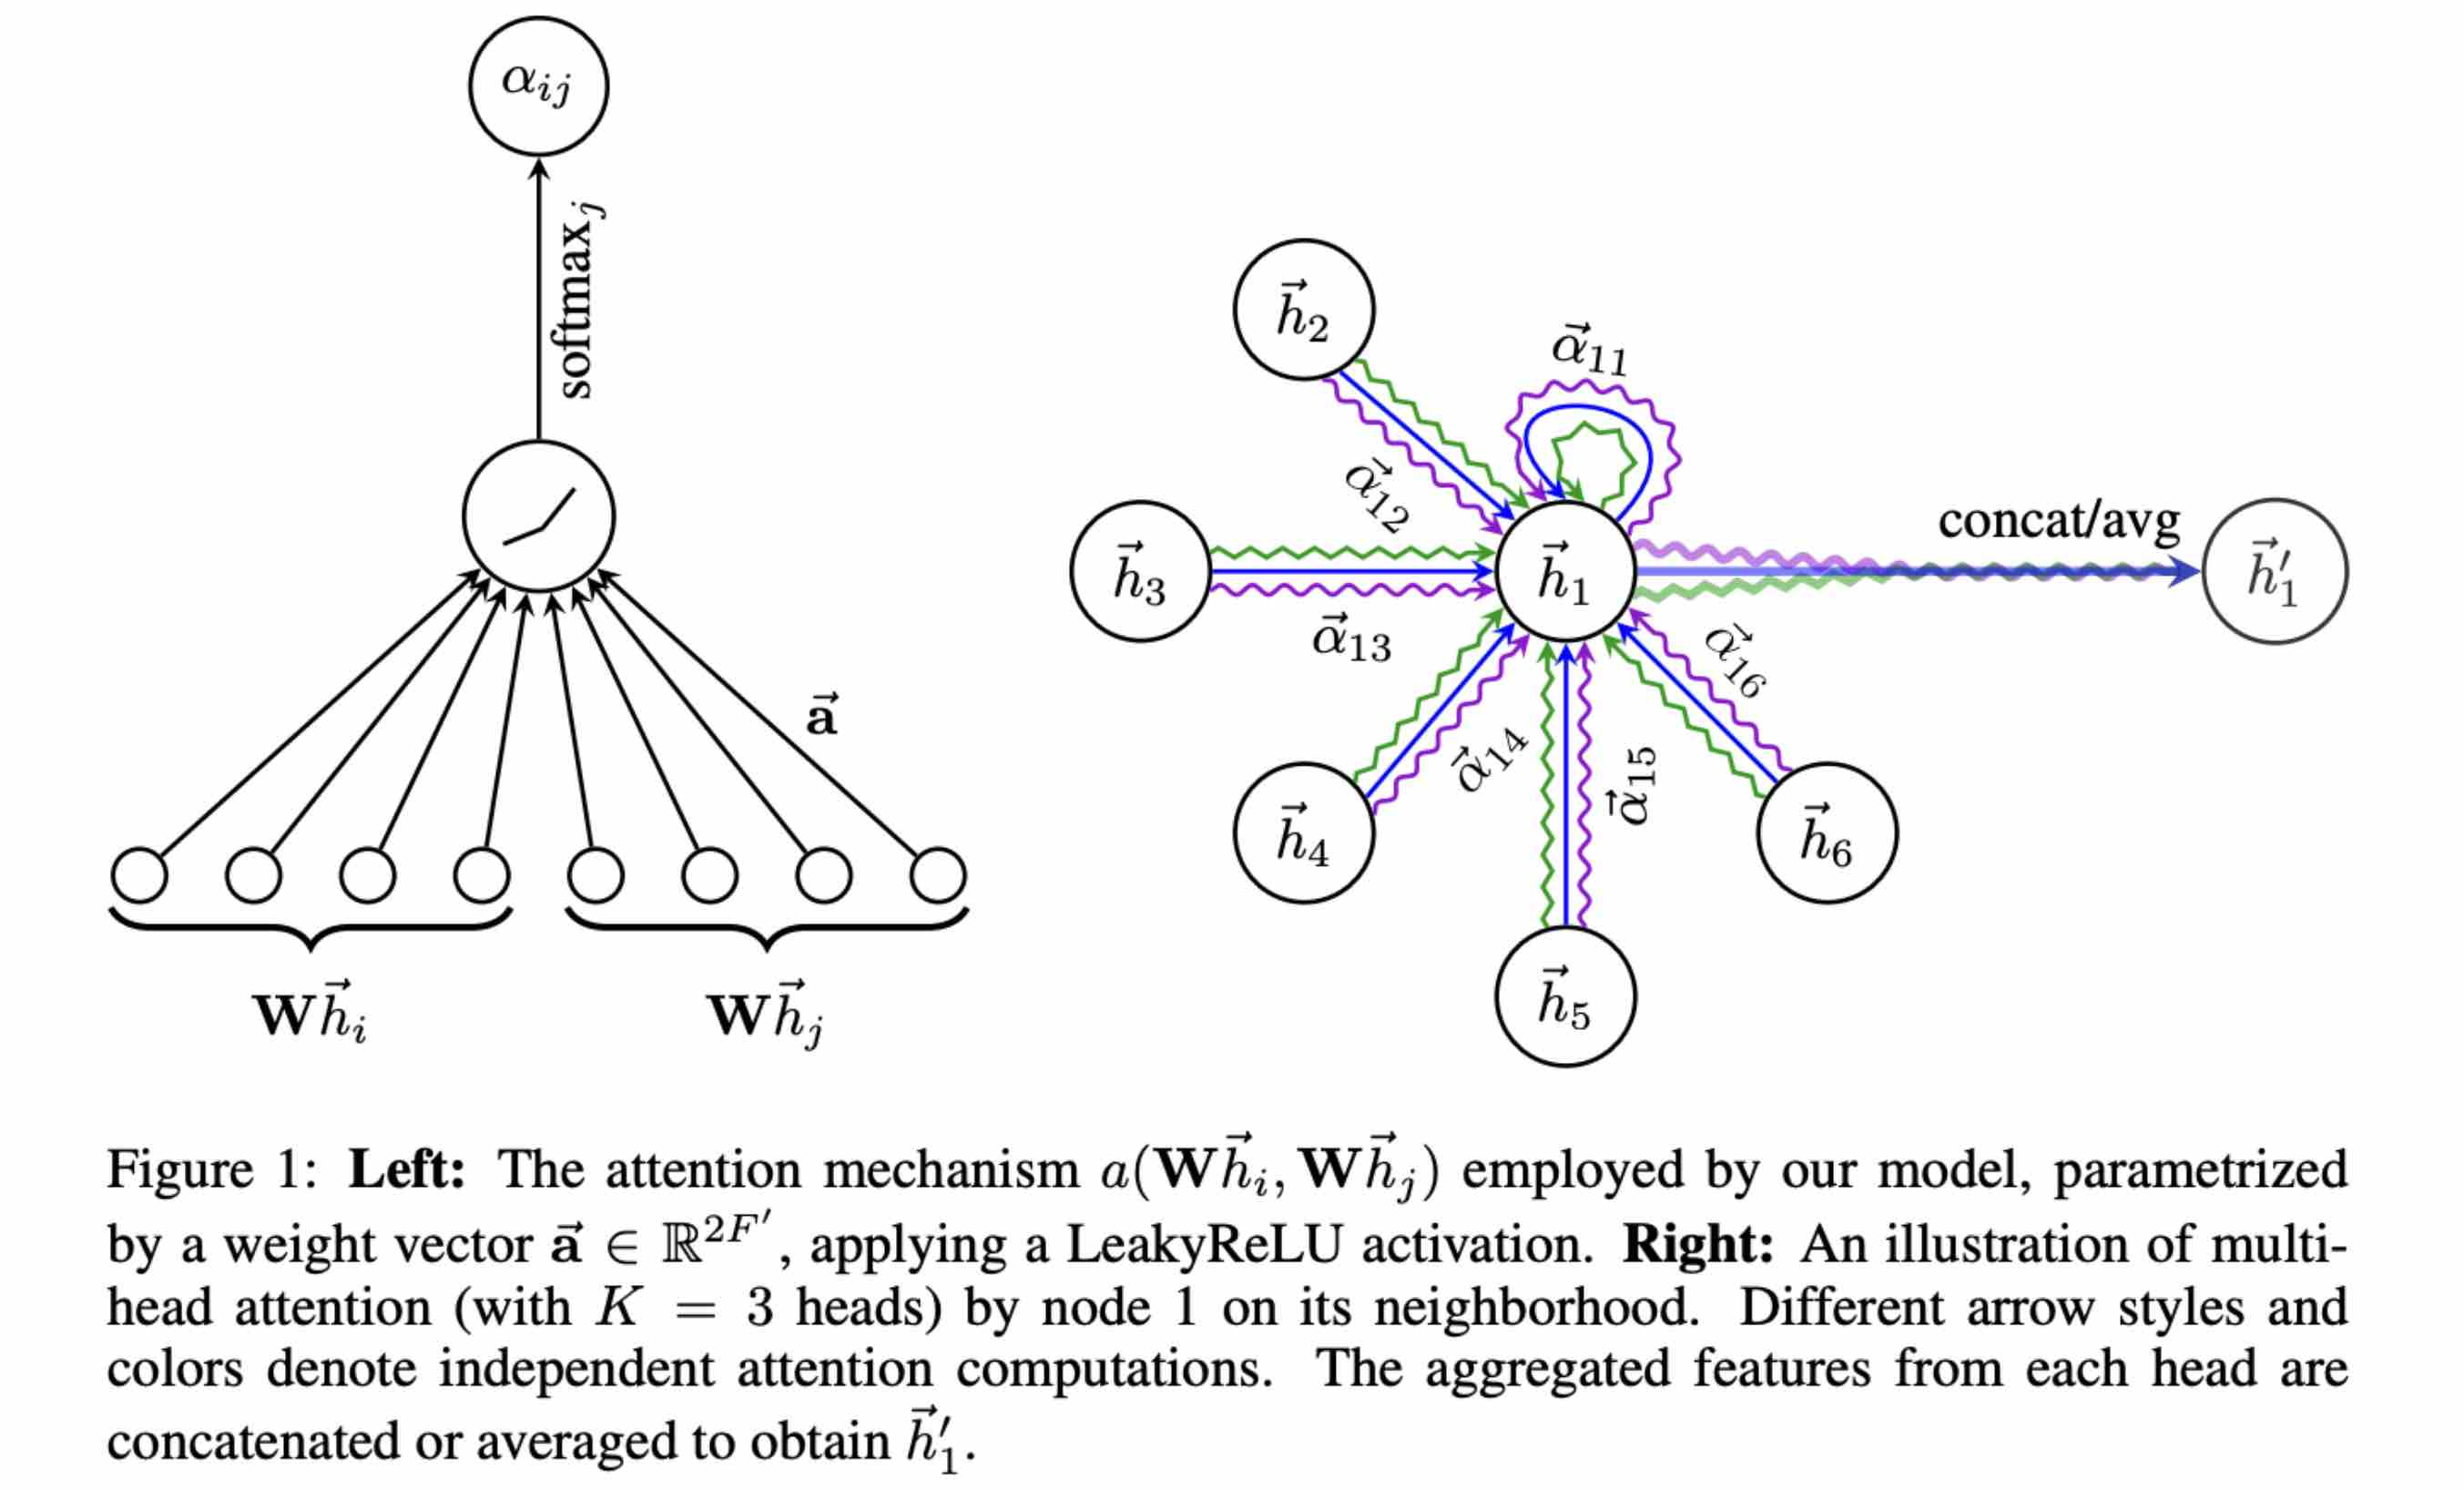

The node feature for node \( i \) is given by:

$$
\mathbf{x}^{\prime}_i = \sum_{j \in \mathcal{N}(i) \cup \{ i \}}
\alpha_{i,j} \, \mathbf{\Theta}_{t} \mathbf{x}_{j}
$$

where the attention coefficients are $( \alpha_{i,j} ) $ are computed as:

$$
\alpha_{i,j} =
\frac{
\exp\left(\mathbf{a}^{\top} \, \mathrm{LeakyReLU}\left(
\mathbf{\Theta}_{s} \mathbf{x}_i + \mathbf{\Theta}_{t} \mathbf{x}_j
\right)\right)}
{\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
\exp\left(\mathbf{a}^{\top} \, \mathrm{LeakyReLU}\left(
\mathbf{\Theta}_{s} \mathbf{x}_i + \mathbf{\Theta}_{t} \mathbf{x}_k
\right)\right)}
$$

If the graph has multi-dimensional edge features \( \mathbf{e}_{i,j} \), the attention becomes:

$$
\alpha_{i,j} =
\frac{
\exp\left(\mathbf{a}^{\top} \, \mathrm{LeakyReLU}\left(
\mathbf{\Theta}_{s} \mathbf{x}_i
+ \mathbf{\Theta}_{t} \mathbf{x}_j
+ \mathbf{\Theta}_{e} \mathbf{e}_{i,j}
\right)\right)}
{\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
\exp\left(\mathbf{a}^{\top} \, \mathrm{LeakyReLU}\left(
\mathbf{\Theta}_{s} \mathbf{x}_i
+ \mathbf{\Theta}_{t} \mathbf{x}_k
+ \mathbf{\Theta}_{e} \mathbf{e}_{i,k}
\right)\right)}
$$

**Note:**  
The matrices $( \mathbf{\Theta}_s)$, $( \mathbf{\Theta}_t)$, and $( \mathbf{\Theta}_e)$ are **learnable weights** that transform node and edge features before computing attention. By learning these transformations, the GNN can focus attention on the most relevant parts of the graph, helping it make more informed predictions.

In [ ]:
class GraphAttention(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(GraphAttention, self).__init__()
        """ GATConv layers """

        self.convs = torch.nn.ModuleList()
        self.activation = nn.ReLU()
        for _ in range(num_layers):
            self.convs.append(GATv2Conv(in_channels, hidden_channels))
            in_channels = hidden_channels

        self.readout = MLP([hidden_channels, hidden_channels, out_channels], norm=None, dropout=0.5)

    def forward(self, data):

        x, edge_index, batch = data.x.to(torch.float), data.edge_index, data.batch

        for conv in self.convs:
            x, attention_weights = conv(x, edge_index,return_attention_weights = True)
            x = self.activation(x)

        return self.readout(global_add_pool(x, batch)), attention_weights

In [ ]:
epochs = 50
hidden_channels = 64
num_layers = 5
lr = 0.0005

model = GraphAttention(in_channels=9, hidden_channels=hidden_channels, out_channels=1, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loss_list = []
val_lost_list = []

for epcoh in range(1, epochs + 1):
        # Train
        model.train()
        for data_minibatch in train_loader:
                data_minibatch = data_minibatch.to(device)
                optimizer.zero_grad()
                out, _ = model(data_minibatch)
                loss = F.l1_loss(out, data_minibatch.y)
                loss.backward()
                optimizer.step()

        # Evaluate on training set
        model.eval()
        total_loss_train = 0
        for data_minibatch in train_loader:
                data_minibatch = data_minibatch.to(device)
                pred, _ = model(data_minibatch)
                loss = F.l1_loss(pred, data_minibatch.y)
                total_loss_train += float(loss) * data_minibatch.num_graphs

        # Evaluate on test set
        model.eval()
        total_loss_test = 0
        for data_minibatch in test_loader:
                data_minibatch = data_minibatch.to(device)
                pred, _ = model(data_minibatch)
                loss = F.l1_loss(pred, data_minibatch.y)
                total_loss_test += float(loss) * data_minibatch.num_graphs

        total_loss_train = total_loss_train / len(train_dataset)
        total_loss_test = total_loss_test / len(test_dataset)

        train_loss_list.append(total_loss_train)
        val_lost_list.append(total_loss_test)

        print(f'Epoch: {epcoh:03d}, Train MAE: {total_loss_train:.4f}, Test MAE: {total_loss_test:.4f}')

Epoch: 001, Train MAE: 1.4934, Test MAE: 1.5711
Epoch: 002, Train MAE: 1.2838, Test MAE: 1.2739
Epoch: 003, Train MAE: 1.2152, Test MAE: 1.2655
Epoch: 004, Train MAE: 1.2190, Test MAE: 1.2786
Epoch: 005, Train MAE: 1.1672, Test MAE: 1.1982
Epoch: 006, Train MAE: 1.1734, Test MAE: 1.2278
Epoch: 007, Train MAE: 1.1312, Test MAE: 1.1627
Epoch: 008, Train MAE: 1.1122, Test MAE: 1.1494
Epoch: 009, Train MAE: 1.0906, Test MAE: 1.1307
Epoch: 010, Train MAE: 1.0773, Test MAE: 1.1267
Epoch: 011, Train MAE: 1.0584, Test MAE: 1.1151
Epoch: 012, Train MAE: 1.0584, Test MAE: 1.1079
Epoch: 013, Train MAE: 1.0132, Test MAE: 1.0516
Epoch: 014, Train MAE: 1.0040, Test MAE: 1.0680
Epoch: 015, Train MAE: 0.9575, Test MAE: 0.9960
Epoch: 016, Train MAE: 0.9220, Test MAE: 0.9912
Epoch: 017, Train MAE: 0.9601, Test MAE: 1.0268
Epoch: 018, Train MAE: 0.9225, Test MAE: 0.9659
Epoch: 019, Train MAE: 0.8773, Test MAE: 0.9208
Epoch: 020, Train MAE: 0.8753, Test MAE: 0.9444
Epoch: 021, Train MAE: 0.8259, Test MAE:

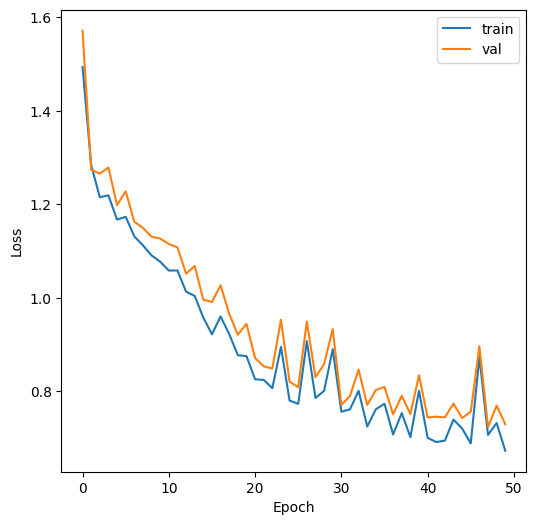

In [ ]:
# Plot learning curve
plt.figure(figsize=(6, 6))
plt.plot(train_loss_list, label='train')
plt.plot(val_lost_list, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

RMSE =  0.9989043
R^2 =  0.77855706


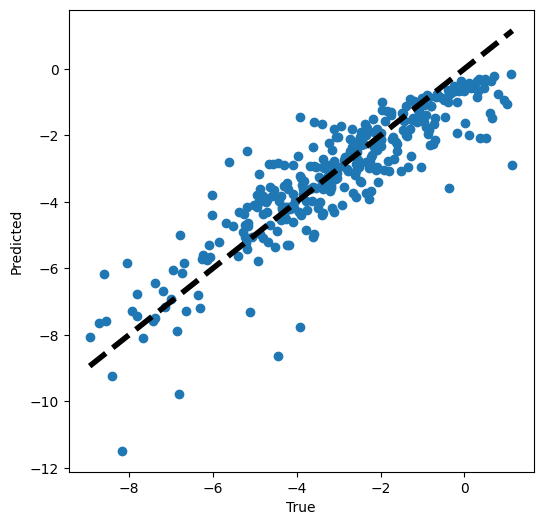

In [ ]:
y_true = []
y_pred = []
for data_minibatch in test_loader:
        data_minibatch = data_minibatch.to(device)
        pred,_ = model(data_minibatch)
        y_true.append(data_minibatch.y.cpu().detach().numpy())
        y_pred.append(pred.cpu().detach().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

RMSE = np.sqrt(np.mean((y_true - y_pred)**2))
print('RMSE = ', RMSE)

R_square = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
print('R^2 = ', R_square)

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

### **Probing the Neural Network**

One of the advantages of the GAT over other frameworks is that they allow for to check what the models are learning under the hood by inverstigating the attention maps. This allows us to correlate known facts with what the model has learnt and understand it better

In [ ]:
out, att_map = model(dataset[0].to(device))

In [ ]:
dataset[0]

Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])

In [ ]:
att_map[1].shape

torch.Size([100, 1])

In [ ]:
att_map[0].shape

torch.Size([2, 100])

In [ ]:
smiles = dataset[0].smiles
mol = Chem.MolFromSmiles(smiles)


In [ ]:
# Create a mapping from atom pairs to bond indices
bond_map = {}
for bond in mol.GetBonds():
    i = bond.GetBeginAtomIdx()
    j = bond.GetEndAtomIdx()
    bond_map[(i, j)] = bond.GetIdx()
    bond_map[(j, i)] = bond.GetIdx()  # if undirected


In [ ]:
edge_index = att_map[0].cpu().numpy()
att_weights = att_map[1].cpu().detach().numpy().flatten()

# Normalize for coloring
att_norm = (att_weights - att_weights.min()) / (att_weights.max() - att_weights.min() + 1e-8)





In [ ]:
from matplotlib import colormaps
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from matplotlib.colors import Normalize
from matplotlib import colormaps
from PIL import Image as PILImage
import io
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [ ]:

cmap = colormaps.get_cmap("viridis")
bond_colors = {}

for (src, tgt), att in zip(edge_index.T, att_norm):
    key = (int(src), int(tgt))
    if key in bond_map:
        bond_idx = bond_map[key]
        rgba = cmap(float(att))
        bond_colors[bond_idx] = tuple(rgba[:3])  # drop alpha

# 5. Draw molecule with all bonds colored
drawer = Draw.MolDraw2DCairo(400, 400)
drawer.DrawMolecule(
    mol,
    highlightAtoms=[],
    highlightBonds=list(bond_colors.keys()),
    highlightBondColors=bond_colors
)
drawer.FinishDrawing()


drawer = Draw.MolDraw2DCairo(400, 400)
opts = drawer.drawOptions()

# Highlight bonds using correct arguments
drawer.DrawMolecule(
    mol,
    highlightAtoms=[],
    highlightBonds=list(bond_colors.keys()),
    highlightBondColors=bond_colors
)

drawer.FinishDrawing()




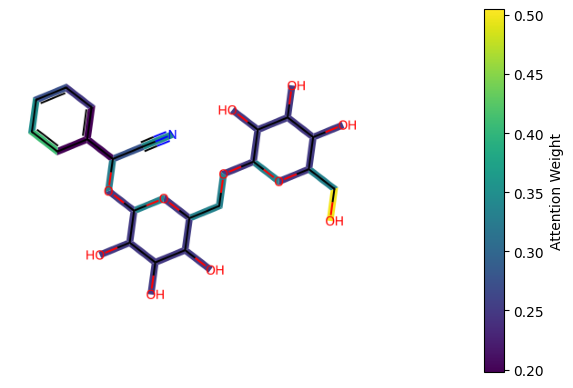

In [ ]:


img_bytes = drawer.GetDrawingText()
img = PILImage.open(io.BytesIO(img_bytes))
img_array = np.array(img)

# Setup plot with 2 columns: molecule + colorbar
fig, ax = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [12, 0.3]})

# Show molecule image
ax[0].imshow(img_array)
ax[0].axis('off')

# Create colorbar for attention weights
norm = Normalize(vmin=att_weights.min(), vmax=att_weights.max())
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap="viridis"), cax=ax[1])
cbar.set_label("Attention Weight")

plt.tight_layout()
plt.show()


Water solubility is generally influenced by polar groups such as hydroxyl (–OH) and cyano (–C≡N), which can form hydrogen bonds. The attention visualization suggests that the model may be focusing more on these groups when predicting solubility. In contrast, nonpolar regions like aromatic rings appear to receive less attention, possibly reflecting their smaller contribution. This pattern implies that the GNN could be learning chemically meaningful features relevant to solubility.

## **Make your own dataset: Molecular property prediction**

The features for molecular graphs in ESOL is relatively naive, let's try to use more reasonable features:

In [ ]:
######################################################################################################################################################
########################### taken from https://github.com/chemprop/chemprop/blob/master/chemprop/features/featurization.py ###########################
######################################################################################################################################################

class Featurization_parameters:
    """
    A class holding molecule featurization parameters as attributes.
    """
    def __init__(self) -> None:

        # Atom feature sizes
        self.MAX_ATOMIC_NUM = 100
        self.ATOM_FEATURES = {
            'atomic_num': list(range(self.MAX_ATOMIC_NUM)),
            'degree': [0, 1, 2, 3, 4, 5],
            'formal_charge': [-1, -2, 1, 2, 0],
            'chiral_tag': [0, 1, 2, 3],
            'num_Hs': [0, 1, 2, 3, 4],
            'hybridization': [
                Chem.rdchem.HybridizationType.SP,
                Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3,
                Chem.rdchem.HybridizationType.SP3D,
                Chem.rdchem.HybridizationType.SP3D2
            ],
        }

        # Distance feature sizes
        self.PATH_DISTANCE_BINS = list(range(10))
        self.THREE_D_DISTANCE_MAX = 20
        self.THREE_D_DISTANCE_STEP = 1
        self.THREE_D_DISTANCE_BINS = list(range(0, self.THREE_D_DISTANCE_MAX + 1, self.THREE_D_DISTANCE_STEP))

        # len(choices) + 1 to include room for uncommon values; + 2 at end for IsAromatic and mass
        self.ATOM_FDIM = sum(len(choices) + 1 for choices in self.ATOM_FEATURES.values()) + 2
        self.EXTRA_ATOM_FDIM = 0
        self.BOND_FDIM = 14
        self.EXTRA_BOND_FDIM = 0
        self.REACTION_MODE = None
        self.EXPLICIT_H = False
        self.REACTION = False
        self.ADDING_H = False
        self.KEEP_ATOM_MAP = False

# Create a global parameter object for reference throughout this module
PARAMS = Featurization_parameters()

def onek_encoding_unk(value: int, choices: List[int]) -> List[int]:
    """
    Creates a one-hot encoding with an extra category for uncommon values.
    :param value: The value for which the encoding should be one.
    :param choices: A list of possible values.
    :return: A one-hot encoding of the :code:`value` in a list of length :code:`len(choices) + 1`.
             If :code:`value` is not in :code:`choices`, then the final element in the encoding is 1.
    """
    encoding = [0] * (len(choices) + 1)
    index = choices.index(value) if value in choices else -1
    encoding[index] = 1

    return encoding

In [ ]:
def atom_features(atom: Chem.rdchem.Atom, functional_groups: List[int] = None) -> List[Union[bool, int, float]]:
    """
    Builds a feature vector for an atom.
    :param atom: An RDKit atom.
    :param functional_groups: A k-hot vector indicating the functional groups the atom belongs to.
    :return: A list containing the atom features.
    """
    if atom is None:
        features = [0] * PARAMS.ATOM_FDIM
    else:
        features = onek_encoding_unk(atom.GetAtomicNum() - 1, PARAMS.ATOM_FEATURES['atomic_num']) + \
            onek_encoding_unk(atom.GetTotalDegree(), PARAMS.ATOM_FEATURES['degree']) + \
            onek_encoding_unk(atom.GetFormalCharge(), PARAMS.ATOM_FEATURES['formal_charge']) + \
            onek_encoding_unk(int(atom.GetChiralTag()), PARAMS.ATOM_FEATURES['chiral_tag']) + \
            onek_encoding_unk(int(atom.GetTotalNumHs()), PARAMS.ATOM_FEATURES['num_Hs']) + \
            onek_encoding_unk(int(atom.GetHybridization()), PARAMS.ATOM_FEATURES['hybridization']) + \
            [1 if atom.GetIsAromatic() else 0] + \
            [atom.GetMass() * 0.01]  # scaled to about the same range as other features
        if functional_groups is not None:
            features += functional_groups
    return features

atom_features(Chem.MolFromSmiles("CC=O").GetAtoms()[0])

[0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0.12011]

In [ ]:
def bond_features(bond: Chem.rdchem.Bond) -> List[Union[bool, int, float]]:
    """
    Builds a feature vector for a bond.
    :param bond: An RDKit bond.
    :return: A list containing the bond features.
    """
    if bond is None:
        fbond = [1] + [0] * (PARAMS.BOND_FDIM - 1)
    else:
        bt = bond.GetBondType()
        fbond = [
            0,  # bond is not None
            bt == Chem.rdchem.BondType.SINGLE,
            bt == Chem.rdchem.BondType.DOUBLE,
            bt == Chem.rdchem.BondType.TRIPLE,
            bt == Chem.rdchem.BondType.AROMATIC,
            (bond.GetIsConjugated() if bt is not None else 0),
            (bond.IsInRing() if bt is not None else 0)
        ]
        fbond += onek_encoding_unk(int(bond.GetStereo()), list(range(6)))
    return fbond

bond_features(Chem.MolFromSmiles("CC=O").GetBonds()[0])

[0, True, False, False, False, False, False, 1, 0, 0, 0, 0, 0, 0]

In [ ]:
######################################################################################################################################################
#################### modified from https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/utils/smiles.html #####################
######################################################################################################################################################

def smiles_to_graph(smiles: str, y: float, atm_idx=None, with_hydrogen: bool = False, kekulize: bool = False) -> 'torch.geometric.data.Data':
    """
    Converts a SMILES string to a :class:`torch_geometric.data.Data`
    instance.

    Args:
        smiles (str): The SMILES string.
        with_hydrogen (bool, optional): If set to :obj:`True`, will store
            hydrogens in the molecule graph. (default: :obj:`False`)
        kekulize (bool, optional): If set to :obj:`True`, converts aromatic
        bonds to single/double bonds. (default: :obj:`False`)
    """
    RDLogger.DisableLog('rdApp.*')

    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        mol = Chem.MolFromSmiles('')
    if with_hydrogen:
        mol = Chem.AddHs(mol)
    if kekulize:
        Chem.Kekulize(mol)

    xs = []
    for atom in mol.GetAtoms():
        xs.append(atom_features(atom))

    x = torch.tensor(xs, dtype=torch.long) #.view(-1, 9)

    edge_indices, edge_attrs = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        e = []
        e.append(bond_features(bond))
        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]

    edge_index = torch.tensor(edge_indices)
    edge_index = edge_index.t().to(torch.long).view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.long) # .view(-1, 3)

    if edge_index.numel() > 0:  # Sort indices.
        perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
        edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

    if atm_idx is not None:
        return Data(x=x, edge_index=edge_index, edge_attr=torch.squeeze(edge_attr), y=torch.tensor([y], dtype=torch.float32), atm_idx=torch.tensor([atm_idx]))
    else:
        return Data(x=x, edge_index=edge_index, edge_attr=torch.squeeze(edge_attr), y=torch.tensor([y], dtype=torch.float32))

graph_temp = smiles_to_graph(smiles="CC=O", y=0.1)
print(graph_temp)
graph_temp.x, graph_temp.edge_index, graph_temp.edge_attr, graph_temp.y

Data(x=[3, 133], edge_index=[2, 4], edge_attr=[4, 14], y=[1])


(tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
          0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
          1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
batch_size = 128
epochs = 50
hidden_channels = 64
num_layers = 5
lr = 0.0005

train_loader = DataLoader([smiles_to_graph(smiles=data.smiles, y=data.y.item()) for data in train_dataset], batch_size, shuffle=True)
test_loader = DataLoader([smiles_to_graph(smiles=data.smiles, y=data.y.item()) for data in test_dataset], batch_size, shuffle=False)

model = GraphAttention(in_channels=133, hidden_channels=hidden_channels, out_channels=1, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loss_list = []
val_lost_list = []

for epcoh in range(1, epochs + 1):
        # Train
        model.train()
        for data_minibatch in train_loader:
                data_minibatch = data_minibatch.to(device)
                optimizer.zero_grad()
                out,_ = model(data_minibatch)
                loss = F.l1_loss(out, data_minibatch.y.unsqueeze(1))
                loss.backward()
                optimizer.step()

        # Evaluate on training set
        model.eval()
        total_loss_train = 0
        for data_minibatch in train_loader:
                data_minibatch = data_minibatch.to(device)
                pred,_ = model(data_minibatch)
                loss = F.l1_loss(pred, data_minibatch.y.unsqueeze(1))
                total_loss_train += float(loss) * data_minibatch.num_graphs

        # Evaluate on test set
        model.eval()
        total_loss_test = 0
        for data_minibatch in test_loader:
                data_minibatch = data_minibatch.to(device)
                pred,_ = model(data_minibatch)
                loss = F.l1_loss(pred, data_minibatch.y.unsqueeze(1))
                total_loss_test += float(loss) * data_minibatch.num_graphs

        total_loss_train /= len(train_dataset)
        total_loss_test /= len(test_dataset)

        train_loss_list.append(total_loss_train)
        val_lost_list.append(total_loss_test)

        print(f'Epoch: {epcoh:03d}, Train MAE: {total_loss_train:.4f}, Test MAE: {total_loss_test:.4f}')

Epoch: 001, Train MAE: 2.3689, Test MAE: 2.4028
Epoch: 002, Train MAE: 1.4146, Test MAE: 1.4521
Epoch: 003, Train MAE: 1.3998, Test MAE: 1.3876
Epoch: 004, Train MAE: 1.3045, Test MAE: 1.3004
Epoch: 005, Train MAE: 1.2990, Test MAE: 1.3277
Epoch: 006, Train MAE: 1.2684, Test MAE: 1.2875
Epoch: 007, Train MAE: 1.2540, Test MAE: 1.2546
Epoch: 008, Train MAE: 1.2242, Test MAE: 1.2427
Epoch: 009, Train MAE: 1.1974, Test MAE: 1.2187
Epoch: 010, Train MAE: 1.1444, Test MAE: 1.1703
Epoch: 011, Train MAE: 1.1054, Test MAE: 1.1403
Epoch: 012, Train MAE: 1.0070, Test MAE: 1.0288
Epoch: 013, Train MAE: 0.9590, Test MAE: 0.9958
Epoch: 014, Train MAE: 0.8702, Test MAE: 0.8955
Epoch: 015, Train MAE: 0.8267, Test MAE: 0.8548
Epoch: 016, Train MAE: 0.9233, Test MAE: 0.9600
Epoch: 017, Train MAE: 0.7797, Test MAE: 0.8128
Epoch: 018, Train MAE: 0.7916, Test MAE: 0.8246
Epoch: 019, Train MAE: 0.7642, Test MAE: 0.7938
Epoch: 020, Train MAE: 0.7369, Test MAE: 0.7704
Epoch: 021, Train MAE: 0.7740, Test MAE:

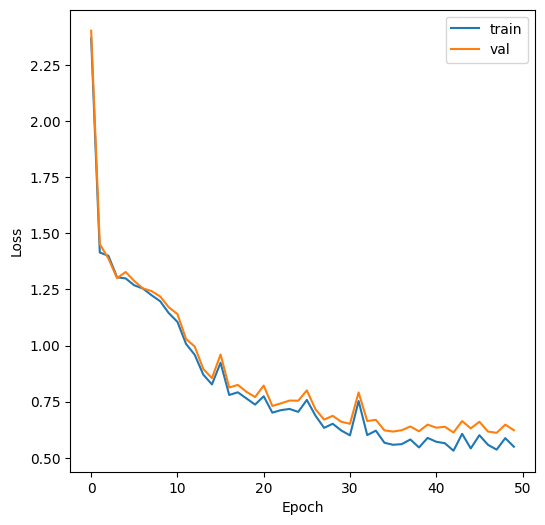

In [ ]:
# Plot learning curve
plt.figure(figsize=(6, 6))
plt.plot(train_loss_list, label='train')
plt.plot(val_lost_list, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

RMSE =  0.88259023
R^2 =  0.82712495


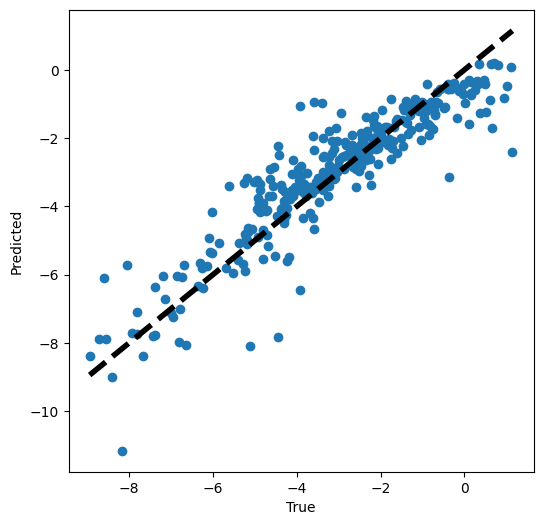

In [ ]:
y_true = []
y_pred = []
for data_minibatch in test_loader:
        data_minibatch = data_minibatch.to(device)
        pred,_ = model(data_minibatch)
        y_true.append(data_minibatch.y.cpu().detach().numpy())
        y_pred.append(pred.cpu().detach().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred).reshape(-1)

RMSE = np.sqrt(np.mean((y_true - y_pred)**2))
print('RMSE = ', RMSE)

R_square = 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)
print('R^2 = ', R_square)

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

## **Further Reading**


##### **General Research Directions**
*Equivariant Graph Neural Networks:*

The ML community remains divided between equivariant and non-equivariant GNN frameworks. Equivariant models offer mathematical elegance and improved data efficiency in settings like 3D molecular structures. When implemented efficiently, they can be competitive in terms of compute. However, recent work (e.g., AlphaFold 3) shows that data augmentation combined with standard architectures can match or exceed performance without explicit equivariance. Message-passing networks with augmentation are typically simpler and more scalable. The choice is nuanced and should be guided by domain-specific needs and empirical results.

 - Thomas et al., Tensor Field Networks: Rotation- and Translation-Equivariant Neural Networks for 3D Point Clouds, NeurIPS 2018
 - Satorras et al., E(n) Equivariant Graph Neural Networks, ICML 2021
 - https://chaitjo.substack.com/p/transformers-vs-equivariant-networks

*Diffusion Models for Molecule Generation:*
Diffusion models have emerged as an important tool for many generative chemistry tasks, including molecule and conformation generation. These models often use GNNs as their backbone to capture molecular structure and dynamics, enabling more chemically valid and diverse generations.

 - Hoogeboom et al., Equivariant Diffusion for Molecule Generation in 3D, ICML 2022

 - Xu et al., GeoDiff: A Geometric Diffusion Model for Molecular Conformation Generation, ICLR 2022

*Pretraining and Self-Supervised Learning (SSL):*
As in NLP and vision, pretraining and SSL techniques are gaining traction in molecular ML. Approaches like contrastive learning, masked atom modeling, and graph-level pretraining help models learn transferable chemical representations, especially valuable when labeled data is limited.

- Hu et al., Strategies for Pre-training Graph Neural Networks, ICLR 2020

- Wang et al., MolCLR: Molecular Contrastive Learning of Representations via Graph Neural Networks, Nature Machine Intelligence 2022



## **Reference**

*   Jure Leskovec, Stanford CS224W: Machine Learning with Graphs
*   https://e3nn.org/
*   PyG official documents: https://pytorch-geometric.readthedocs.io/en/latest/index.html
*   https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
*   https://medium.com/swlh/geometric-deep-learning-group-equivariant-convolutional-networks-ec687c7a7b41

